In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import sklearn.preprocessing as preprocessing

%matplotlib inline

In [0]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score

In [0]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier 

## Uvod

U rješavanju problema klasifikacije osoba prema primanjima na temelju popisnih podataka koristit ćemo nekoliko algoritama strojnog učenja. 

Problem ćemo pokušati rješiti sa sljedećim algoritmima:
*   Logistička regresija
*   Random Forest
*   SVM
*   KNN algoritam
*   Naive Bayes
*   Neuronske mreže

Na nekoliko različitih načina preuredit ćemo naše podatke te uspoređivati uspješnost algoritama s obzirom na različite algoritme i uređivanje podataka. Prilikom razvoja algoritama koristit ćemo PCA (Analizu glavnih komponenata) te vidjeti utječe li taj postupak na poboljšanje rezultata. Također, pri analizi rezultata promatrat ćemo razliku uspješnosti algoritama s obzirom na način rješavanja problema nedostajućih vrijednosti.

Mjeru uspješnosti mjerit ćemo pomoću roc-auc score-a te točnosti (accuracy), iako podaci nisu balansirani (75% instanci ima prihode <=50k dolara, dok ostatak ima više od 50k dolara) pa ćemo kao glavnu mjeru evaluacije uzeti roc_auc_score koji predstavlja površinu ispod ROC krivulje, a točnost koristiti kao usporedbu s rezultatima iz [1] i 4]. Rezultate dobivene korištenjem metrika evaluacije uspoređivat ćemo s rezultatima iz literature.

## Učitavanje podataka i preuređivanje - prvi način

Primjenjivat ćemo algoritme strojnog učenja na našem skupu podataka i postepeno mijenjati i preuređivati podatke kako bi dobili bolje rezultate.

Sljedeće dvije ćelije se pokreću u google colab-u, treća u anacondi.

In [5]:
from google.colab import files
uploaded = files.upload()

Saving adult.csv to adult (1).csv


In [0]:
import io

data = pd.read_csv(io.BytesIO(uploaded['adult.csv']))

# Dataset is now stored in a Pandas Dataframe data

In [0]:
data = pd.read_csv('adult.csv')

In [7]:
data.head()

,Age,Workclass,fnlwgt,Education,Education-num,Marital-status,Occupation,Relationship,Race,Sex,Capital-gain,Capital-loss,Hours-per-week,Native-country,Income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


Pogledamo gdje se nalaze '?'. Oni predstavljaju "missing values".

In [8]:
printseries = pd.DataFrame(columns=['Atribut', 'Occurance'])
j = 0
for i in range(1,np.size(data.columns)):
    if not np.issubdtype(data.iloc[:,i],np.number):
        printseries.loc[j] = [data.columns.values[i],data[data.iloc[:,i] == '?'].shape[0]]
        j = j + 1
printseries

,Atribut,Occurance
0,Workclass,2799
1,Education,0
2,Marital-status,0
3,Occupation,2809
4,Relationship,0
5,Race,0
6,Sex,0
7,Native-country,857
8,Income,0


Mijenjamo vrijednosti target-a tako da 0 znači <=50K, a 1 suprotno.

In [0]:
mapa = {'<=50K' : 0, '>50K' : 1}
data = data.replace({'Income' : mapa})
#data

### Unique values

Za svako kategorijsko svojstvo možemo naći koliko ima različitih vrijednosti.

In [10]:
print(data['Income'].value_counts(), '\n', data['Income'].value_counts(normalize=1))

0    37155
1    11687
Name: Income, dtype: int64 
 0    0.760718
1    0.239282
Name: Income, dtype: float64


In [11]:
data['Workclass'].unique()

array(['Private', 'Local-gov', '?', 'Self-emp-not-inc', 'Federal-gov',
       'State-gov', 'Self-emp-inc', 'Without-pay', 'Never-worked'],
      dtype=object)

In [12]:
data['Marital-status'].unique()

array(['Never-married', 'Married-civ-spouse', 'Widowed', 'Divorced',
       'Separated', 'Married-spouse-absent', 'Married-AF-spouse'],
      dtype=object)

In [13]:
data['Occupation'].unique()

array(['Machine-op-inspct', 'Farming-fishing', 'Protective-serv', '?',
       'Other-service', 'Prof-specialty', 'Craft-repair', 'Adm-clerical',
       'Exec-managerial', 'Tech-support', 'Sales', 'Priv-house-serv',
       'Transport-moving', 'Handlers-cleaners', 'Armed-Forces'],
      dtype=object)

In [14]:
data['Relationship'].unique()

array(['Own-child', 'Husband', 'Not-in-family', 'Unmarried', 'Wife',
       'Other-relative'], dtype=object)

In [15]:
data['Race'].unique()

array(['Black', 'White', 'Asian-Pac-Islander', 'Other',
       'Amer-Indian-Eskimo'], dtype=object)

In [16]:
data['Sex'].unique()

array(['Male', 'Female'], dtype=object)

In [17]:
data['Native-country'].unique()

array(['United-States', '?', 'Peru', 'Guatemala', 'Mexico',
       'Dominican-Republic', 'Ireland', 'Germany', 'Philippines',
       'Thailand', 'Haiti', 'El-Salvador', 'Puerto-Rico', 'Vietnam',
       'South', 'Columbia', 'Japan', 'India', 'Cambodia', 'Poland',
       'Laos', 'England', 'Cuba', 'Taiwan', 'Italy', 'Canada', 'Portugal',
       'China', 'Nicaragua', 'Honduras', 'Iran', 'Scotland', 'Jamaica',
       'Ecuador', 'Yugoslavia', 'Hungary', 'Hong', 'Greece',
       'Trinadad&Tobago', 'Outlying-US(Guam-USVI-etc)', 'France',
       'Holand-Netherlands'], dtype=object)

### Label Encoding

Radimo label encoding.

In [18]:
mapa = {'Private' : 0, 'Local-gov' : 1, 'Self-emp-not-inc' : 2, 'Federal-gov' : 3,
       'State-gov' : 4, 'Self-emp-inc' : 5, 'Without-pay' : 6, 'Never-worked' : 7}
data = data.replace({'Workclass' : mapa})
mapa = {'Never-married' : 0, 'Married-civ-spouse' : 1, 'Widowed' : 2, 'Divorced' : 3,
       'Separated' : 4, 'Married-spouse-absent' : 5, 'Married-AF-spouse' : 6}
data = data.replace({'Marital-status' : mapa})
mapa = {'Machine-op-inspct' : 0, 'Farming-fishing' : 1, 'Protective-serv' : 2,
       'Other-service' : 3, 'Prof-specialty' : 4, 'Craft-repair' : 5, 'Adm-clerical' : 6,
       'Exec-managerial' : 7, 'Tech-support' : 8, 'Sales' : 9, 'Priv-house-serv' : 10,
       'Transport-moving' : 11, 'Handlers-cleaners' : 12, 'Armed-Forces' : 13}
data = data.replace({'Occupation' : mapa})
mapa = {'Own-child' : 0, 'Husband' : 1, 'Not-in-family' : 2, 'Unmarried' : 3, 'Wife' : 4,
       'Other-relative' : 5}
data = data.replace({'Relationship' : mapa})
mapa = {'Black' : 0, 'White' : 1, 'Asian-Pac-Islander' : 2, 'Other' : 3,
       'Amer-Indian-Eskimo' : 4}
data = data.replace({'Race' : mapa})
mapa = {'Male': 0, 'Female': 1}
data = data.replace({'Sex' : mapa})
mapa = {'United-States' : 0, 'Peru' : 1, 'Guatemala' : 2, 'Mexico' : 3,
       'Dominican-Republic' : 4, 'Ireland' : 5, 'Germany' : 6, 'Philippines' : 7,
       'Thailand' : 8, 'Haiti' : 9, 'El-Salvador' : 10, 'Puerto-Rico' : 11, 'Vietnam' : 12,
       'South' : 13, 'Columbia' : 14, 'Japan' : 15, 'India' : 16, 'Cambodia' : 17, 'Poland' : 18,
       'Laos' : 19, 'England' : 20, 'Cuba' : 21, 'Taiwan' : 22, 'Italy' : 23, 'Canada' : 24, 'Portugal' : 25,
       'China' : 26, 'Nicaragua' : 27, 'Honduras' : 28, 'Iran' : 29, 'Scotland' : 30, 'Jamaica' : 31,
       'Ecuador' : 32, 'Yugoslavia' : 33, 'Hungary' : 34, 'Hong' : 35, 'Greece' : 36,
       'Trinadad&Tobago' : 37, 'Outlying-US(Guam-USVI-etc)' : 38, 'France' : 39,
       'Holand-Netherlands' : 40}
data = data.replace({'Native-country' : mapa})
data

,Age,Workclass,fnlwgt,Education,Education-num,Marital-status,Occupation,Relationship,Race,Sex,Capital-gain,Capital-loss,Hours-per-week,Native-country,Income
0,25,0,226802,11th,7,0,0,0,0,0,0,0,40,0,0
1,38,0,89814,HS-grad,9,1,1,1,1,0,0,0,50,0,0
2,28,1,336951,Assoc-acdm,12,1,2,1,1,0,0,0,40,0,1
3,44,0,160323,Some-college,10,1,0,1,0,0,7688,0,40,0,1
4,18,?,103497,Some-college,10,0,?,0,1,1,0,0,30,0,0
5,34,0,198693,10th,6,0,3,2,1,0,0,0,30,0,0
6,29,?,227026,HS-grad,9,0,?,3,0,0,0,0,40,0,0
7,63,2,104626,Prof-school,15,1,4,1,1,0,3103,0,32,0,1
8,24,0,369667,Some-college,10,0,3,3,1,1,0,0,40,0,0
9,55,0,104996,7th-8th,4,1,5,1,1,0,0,0,10,0,0


Svojstva Capital-gain i Capital-loss možemo prevoriti u kategorijska s obzirom na vrijednosti tih svojstava.

In [19]:
data['Capital-gain'].describe()

count    48842.000000
mean      1079.067626
std       7452.019058
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      99999.000000
Name: Capital-gain, dtype: float64

In [20]:
(data['Capital-gain']<10000).sum()

47708

In [0]:
a = np.array(data['Capital-gain'].values.tolist())

b = np.where(np.logical_and(a>=1, a<=10000), 1, a)

b = np.where(b>10000, 2, b).tolist()
data['Capital-gain'] = b
#data

In [22]:
data['Capital-loss'].describe()

count    48842.000000
mean        87.502314
std        403.004552
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       4356.000000
Name: Capital-loss, dtype: float64

In [23]:
(data['Capital-loss']<1000).sum()

46605

In [0]:
a = np.array(data['Capital-loss'].values.tolist())

b = np.where(np.logical_and(a>=1, a<=1000), 1, a)

b = np.where(b>1000, 2, b).tolist()
data['Capital-loss'] = b
#data

In [25]:
data['Capital-loss'].unique()

array([0, 2, 1])

Mičemo svojstvo Education jer već imamo Education-num koji također predstavlja razinu obrazovanja, ali od najniže razine do najveće.

In [0]:
data=data.drop('Education',axis=1)

In [27]:
data.head()

,Age,Workclass,fnlwgt,Education-num,Marital-status,Occupation,Relationship,Race,Sex,Capital-gain,Capital-loss,Hours-per-week,Native-country,Income
0,25,0,226802,7,0,0,0,0,0,0,0,40,0,0
1,38,0,89814,9,1,1,1,1,0,0,0,50,0,0
2,28,1,336951,12,1,2,1,1,0,0,0,40,0,1
3,44,0,160323,10,1,0,1,0,0,1,0,40,0,1
4,18,?,103497,10,0,?,0,1,1,0,0,30,0,0


Nedostajuće vrijednosti ćemo prvo pokušati interpretirati kao zasebnu kategoriju. Kasnije ćemo maknuti sve instance koje imaju vrijednost nekog svojstva nepoznato pa pokušati primjeniti algoritme na tom izmjenjenom skupu podataka.

In [0]:
data['Workclass'].replace('?', 8, inplace=True)

In [0]:
data['Occupation'].replace('?', 6, inplace=True)
data['Native-country'].replace('?', 41, inplace=True)

In [30]:
data.head()

,Age,Workclass,fnlwgt,Education-num,Marital-status,Occupation,Relationship,Race,Sex,Capital-gain,Capital-loss,Hours-per-week,Native-country,Income
0,25,0,226802,7,0,0,0,0,0,0,0,40,0,0
1,38,0,89814,9,1,1,1,1,0,0,0,50,0,0
2,28,1,336951,12,1,2,1,1,0,0,0,40,0,1
3,44,0,160323,10,1,0,1,0,0,1,0,40,0,1
4,18,8,103497,10,0,6,0,1,1,0,0,30,0,0


#### Logisticka regresija

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did

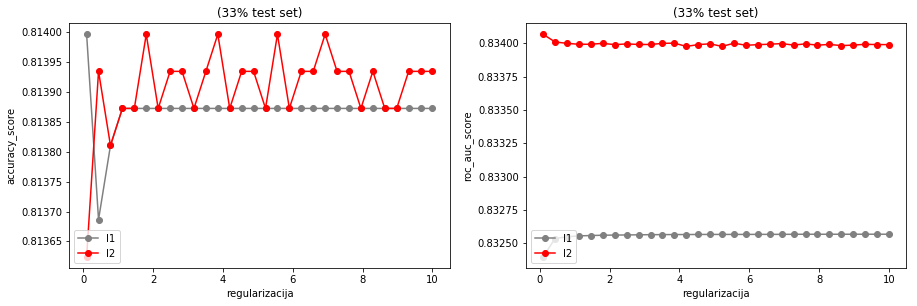

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4.5))

C_array = np.linspace(0.1,10.0,30)
acc_l1 = []
acc_l2 = []
roc_auc_list1 = []
roc_auc_list2 = []

for c_value in C_array:
    
    data_train, data_test = train_test_split(data, test_size=0.33, random_state=50)
    
    model_l1 = Pipeline([('logistic', LogisticRegression(penalty='l1',C=c_value, solver='liblinear',random_state=1))])
    model_l2 = Pipeline([('logistic', LogisticRegression(penalty='l2',C=c_value, solver='newton-cg', max_iter=100000, random_state=1))]) 

    model_l1 = model_l1.fit(data_train.drop('Income',axis=1),data_train['Income'])
    model_l2 = model_l2.fit(data_train.drop('Income',axis=1),data_train['Income'])
    
    probs = model_l1.predict_proba(data_test.drop('Income',axis=1))
    probs = probs[:,1]
    roc_auc_l1 = roc_auc_score(data_test['Income'], probs)
    
    probs = model_l2.predict_proba(data_test.drop('Income',axis=1))
    probs = probs[:,1]
    roc_auc_l2 = roc_auc_score(data_test['Income'], probs)

    acc_l1.append(model_l1.score(data_test.drop('Income',axis=1),data_test['Income'])) 
    acc_l2.append(model_l2.score(data_test.drop('Income',axis=1),data_test['Income']))
                  
    roc_auc_list1.append(roc_auc_l1)
    roc_auc_list2.append(roc_auc_l2)
    
ax[0].plot(C_array, acc_l1, '-o', color='gray', label='l1') 
ax[0].plot(C_array, acc_l2, '-o', color='red', label='l2') 
ax[1].plot(C_array, roc_auc_list1, '-o', color='gray', label='l1') 
ax[1].plot(C_array, roc_auc_list2, '-o', color='red', label='l2') 

ax[0].legend(loc='lower left')
ax[1].legend(loc='lower left')

ax[0].set(title='(33% test set)', xlabel='regularizacija',ylabel='accuracy_score')
ax[1].set(title='(33% test set)', xlabel='regularizacija',ylabel='roc_auc_score')

plt.show();

Accuracy se kreće oko 0.81 neovisno o vrijednosti parametra C, dok roc_auc vrijednost iznosi približno 0.83 što znači da nema pretjerane razlike koje parametre uzmemo.

In [32]:
from sklearn.metrics import precision_score

data_train, data_test = train_test_split(data, test_size=0.33, random_state=50)
    
model_l1 = Pipeline([('logistic', LogisticRegression(penalty='l1',C=0.75, solver='liblinear'))])
model_l1 = model_l1.fit(data_train.drop('Income',axis=1),data_train['Income'])
data_target_pred = model_l1.predict(data_test.drop('Income',axis=1))
print(precision_score(data_test['Income'], data_target_pred, average="micro"))
print(precision_score(data_test['Income'], data_target_pred, average="macro"))
print(precision_score(data_test['Income'], data_target_pred, average="weighted"))
print(precision_score(data_test['Income'], data_target_pred, average="binary"))
print(precision_score(data_test['Income'], data_target_pred, average=None))

0.8138106464821938
0.7611764890351043
0.7997693248871588
0.6866807610993657
[0.83567222 0.68668076]


Konfuzijska matrica

In [33]:
from sklearn.metrics import confusion_matrix
confusion_matrix(data_test['Income'],data_target_pred)

array([[11493,   741],
       [ 2260,  1624]])

In [34]:
from sklearn.metrics import recall_score
data_target_pred = model_l1.predict(data_test.drop('Income',axis=1))
print(recall_score(data_test['Income'],data_target_pred))

0.4181256436663234


Vidimo je da ovakvim pristupom imamo nešto lošiju preciznost i osjetljivost.

#### Random Forest

Random forest algoritam. Također probat ćemo smanjiti dimenzionalnost podataka.

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('Income',axis=1), data["Income"], test_size=0.33,random_state=50)

In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

clf=RandomForestClassifier(n_estimators=100)

clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.839868470033503


In [38]:
probs = clf.predict_proba(X_test)
probs = probs[:,1]
auc_score = roc_auc_score(y_test, probs)
print("AUC: %.4f" % auc_score)

AUC: 0.8875


In [0]:
columns = data.columns
columns = columns[:-1]

Ispisujemo najvažnija svojstva koje je RandomForest odredio.

In [40]:
feature_imp = pd.Series(clf.feature_importances_,index=columns).sort_values(ascending=False)
feature_imp 

fnlwgt            0.187207
Age               0.173992
Education-num     0.137957
Marital-status    0.100448
Hours-per-week    0.091039
Occupation        0.074590
Capital-gain      0.066575
Relationship      0.061640
Workclass         0.041179
Sex               0.018350
Native-country    0.017787
Race              0.015512
Capital-loss      0.013725
dtype: float64

No handles with labels found to put in legend.


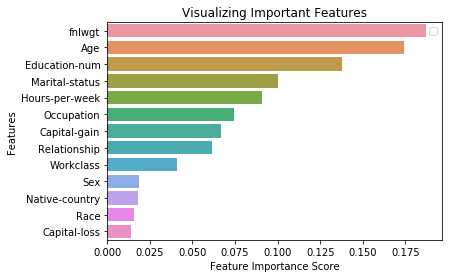

In [41]:
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

In [0]:
data_droped = data[['fnlwgt','Age','Education-num','Hours-per-week','Marital-status','Occupation',
                   'Relationship','Capital-gain','Workclass','Income']]

In [0]:
X_train, X_test, y_train, y_test = train_test_split(data_droped.drop('Income',axis=1), data_droped["Income"], test_size=0.33,random_state=50)

In [44]:
clf=RandomForestClassifier(n_estimators=100)

clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8342226082640526


In [45]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,y_pred)

array([[11197,  1037],
       [ 1635,  2249]])

In [46]:
probs = clf.predict_proba(X_test)
probs = probs[:,1]
auc_score = roc_auc_score(y_test, probs)
print("AUC: %.4f" % auc_score)

AUC: 0.8838


#### KNN i Naive-Bayes algoritmi

In [47]:
data_train, data_test = train_test_split(data, test_size=0.33, random_state=42)

knn = KNeighborsClassifier(n_neighbors=5, weights='distance', algorithm='ball_tree', p=1)
knn.fit(data_train.drop('Income',axis=1),data_train['Income'])
score_knn = knn.score(data_test.drop('Income',axis=1),data_test['Income'])
print('The accuracy of the KNN Model is',score_knn)

The accuracy of the KNN Model is 0.7336518178434049


In [48]:
probs = knn.predict_proba(data_test.drop('Income',axis=1))
probs = probs[:,1]
auc_score = roc_auc_score(data_test['Income'], probs)
print("AUC: %.4f" % auc_score)

AUC: 0.6353


In [49]:
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')
knn.fit(data_train.drop('Income',axis=1),data_train['Income'])
score_knn = knn.score(data_test.drop('Income',axis=1),data_test['Income'])
print('The accuracy of the KNN Model is',score_knn)

The accuracy of the KNN Model is 0.7262687678372006


In [50]:
probs = knn.predict_proba(data_test.drop('Income',axis=1))
probs = probs[:,1]
auc_score = roc_auc_score(data_test['Income'], probs)
print("AUC: %.4f" % auc_score)

AUC: 0.6145


In [51]:
gaussian = GaussianNB()
gaussian.fit(data_train.drop('Income',axis=1),data_train['Income'])
score_gaussian = gaussian.score(data_test.drop('Income',axis=1),data_test['Income'])
print('The accuracy of Gaussian Naive Bayes is', score_gaussian)
probs = gaussian.predict_proba(data_test.drop('Income',axis=1))
probs = probs[:,1]
auc_score = roc_auc_score(data_test['Income'], probs)
print("AUC: %.4f" % auc_score)

The accuracy of Gaussian Naive Bayes is 0.7889316292343963
AUC: 0.8055


Možemo uočiti kako smo Random Forest algoritmom te provedbom algoritma sa smanjenom dimenzionalnosti ( nakon što smo izbacili najmanje važna svojstva ) dobili bolje rezultate, točnost je oko 0.84, a roc-auc score oko 0.89. Kod algoritama KNN  te također isto vrijedi za SVM, podaci trebaju biti normalizirani pa su zato rezultati lošiji. U sljedećim točkama uzet ćemo to u obzir.


### OneHot encoding

U dosadašnjim algoritmima koristili smo samo Label encoding, tj. za sva svojstva smo nenamjerno pretpostavili da postoji ordinalnost među podacima što većinom nije slučaj. Zato nadalje koristimo OneHot Encoder.

In [52]:
from sklearn.preprocessing import OneHotEncoder
data2 = data[['Workclass','Race','Education-num','Marital-status','Occupation',
                   'Relationship','Capital-gain','Capital-loss','Native-country','Sex']]
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
data_ohe = ohe.fit_transform(data2)
data_ohe

array([[1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 1., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [53]:
np.size(data_ohe,1)

107

In [54]:
data3 = data.drop("Income",axis=1)
data3 = data3[["Age","fnlwgt","Hours-per-week"]]
data3

,Age,fnlwgt,Hours-per-week
0,25,226802,40
1,38,89814,50
2,28,336951,40
3,44,160323,40
4,18,103497,30
5,34,198693,30
6,29,227026,40
7,63,104626,32
8,24,369667,40
9,55,104996,10


In [55]:
for i in range(0,107):
    columni="column"+str(i)
    data3[columni] = data_ohe[:,i]
    
data3

,Age,fnlwgt,Hours-per-week,column0,column1,column2,column3,column4,column5,column6,column7,column8,column9,column10,column11,column12,column13,column14,column15,column16,column17,column18,column19,column20,column21,column22,column23,column24,column25,column26,column27,column28,column29,column30,column31,column32,column33,column34,column35,column36,...,column67,column68,column69,column70,column71,column72,column73,column74,column75,column76,column77,column78,column79,column80,column81,column82,column83,column84,column85,column86,column87,column88,column89,column90,column91,column92,column93,column94,column95,column96,column97,column98,column99,column100,column101,column102,column103,column104,column105,column106
0,25,226802,40,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,38,89814,50,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,28,336951,40,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,44,160323,40,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,18,103497,30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,34,198693,30,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6,29,227026,40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
7,63,104626,32,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8,24,369667,40,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9,55,104996,10,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [56]:
data_train,data_test,y_train, y_test = train_test_split(data3,data["Income"], test_size=0.33, random_state=50)

model = Pipeline([('logistic', LogisticRegression(penalty='l1',C=0.8, solver='liblinear'))]) 
model.fit(data_train, y_train)
accuracy_test = model.score(data_test,y_test)

print("Accuracy test:", accuracy_test )
probs = model.predict_proba(data_test)
probs = probs[:,1]
auc_score = roc_auc_score(y_test, probs)
print("AUC: %.4f" % auc_score)

Accuracy test: 0.845700459114034
AUC: 0.8991


In [0]:
X_train, X_test, y_train, y_test = train_test_split(data3, data["Income"], test_size=0.33, random_state=50)

In [58]:
clf=RandomForestClassifier(n_estimators=100)

clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
probs = clf.predict_proba(X_test)
probs = probs[:,1]
auc_score = roc_auc_score(y_test, probs)
print("AUC: %.4f" % auc_score)

Accuracy: 0.8388137486040451
AUC: 0.8853


In [59]:
feature_imp = pd.Series(clf.feature_importances_,index=data3.columns).sort_values(ascending=False)
feature_imp

fnlwgt            0.173614
Age               0.165625
Hours-per-week    0.090190
column31          0.055747
column52          0.046759
column57          0.031022
column30          0.028762
column59          0.027758
column26          0.024038
column44          0.020861
column41          0.020168
column27          0.016540
column22          0.012874
column105         0.012224
column0           0.011697
column55          0.010310
column53          0.010041
column2           0.009084
column58          0.009082
column28          0.008942
column23          0.008927
column51          0.008327
column106         0.007875
column62          0.007772
column60          0.007713
column40          0.007701
column42          0.007309
column46          0.007129
column33          0.006897
column10          0.006693
                    ...   
column75          0.000359
column99          0.000351
column85          0.000346
column36          0.000313
column94          0.000311
column102         0.000305
c

In [0]:
importantfeat=feature_imp[0:80]
keys_imp = importantfeat.keys()
listkeys = keys_imp.tolist()
#listkeys

In [0]:
data4 = data3[listkeys]

In [0]:
X_train, X_test, y_train, y_test = train_test_split(data4, data["Income"], test_size=0.33, random_state=50)

In [63]:
clf=RandomForestClassifier(n_estimators=100)

clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
probs = clf.predict_proba(X_test)
probs = probs[:,1]
auc_score = roc_auc_score(y_test, probs)
print("AUC: %.4f" % auc_score)

Accuracy: 0.8391860032262067
AUC: 0.8862


In [64]:
data_train,data_test,y_train, y_test = train_test_split(data3,data["Income"], test_size=0.33, random_state=50)

model = Pipeline([('logistic', LogisticRegression(penalty='l1',C=0.8, solver='liblinear'))]) 
model.fit(data_train, y_train)
accuracy_test = model.score(data_test,y_test)
print("Accuracy:",accuracy_test)
probs = model.predict_proba(data_test)
probs = probs[:,1]
auc_score = roc_auc_score(y_test, probs)
print("AUC: %.4f" % auc_score)

Accuracy: 0.8459486288621417
AUC: 0.8991


Nakon što smo primjenili OneHot encoding i logističku regresiju točnost je porasla na 0.85 što je uspredivo s rezultatima iz [4]. Također vrijednosti roc_auc su veće i sad iznose oko 0.90 te je to usporedivo s rezultatima iz [7].

Probajmo još maknuti sve one instance u kojima se javljaju nedostajuće vrijednosti.

In [65]:
from google.colab import files
uploaded = files.upload()

Saving adult.csv to adult (2).csv


In [0]:
import io

data = pd.read_csv(io.BytesIO(uploaded['adult.csv']))

U anaconda okruženju pokrenuti ovu ćeliju umjesto prethodne dvije.

In [0]:
data = pd.read_csv('adult.csv')

In [67]:
data_noNaN=data[data["Workclass"]!='?']
data_noNaN = data_noNaN[data_noNaN["Occupation"]!='?']
data_noNaN = data_noNaN[data_noNaN["Native-country"]!='?']
data_noNaN = data_noNaN.reset_index(drop=True)
data_noNaN

,Age,Workclass,fnlwgt,Education,Education-num,Marital-status,Occupation,Relationship,Race,Sex,Capital-gain,Capital-loss,Hours-per-week,Native-country,Income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,34,Private,198693,10th,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,<=50K
5,63,Self-emp-not-inc,104626,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,3103,0,32,United-States,>50K
6,24,Private,369667,Some-college,10,Never-married,Other-service,Unmarried,White,Female,0,0,40,United-States,<=50K
7,55,Private,104996,7th-8th,4,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,10,United-States,<=50K
8,65,Private,184454,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,6418,0,40,United-States,>50K
9,36,Federal-gov,212465,Bachelors,13,Married-civ-spouse,Adm-clerical,Husband,White,Male,0,0,40,United-States,<=50K


In [68]:
mapa = {'<=50K' : 0, '>50K' : 1}
data_noNaN = data_noNaN.replace({'Income' : mapa})

mapa = {'Private' : 0, 'Local-gov' : 1, 'Self-emp-not-inc' : 2, 'Federal-gov' : 3,
       'State-gov' : 4, 'Self-emp-inc' : 5, 'Without-pay' : 6, 'Never-worked' : 7}
data_noNaN = data_noNaN.replace({'Workclass' : mapa})
mapa = {'Never-married' : 0, 'Married-civ-spouse' : 1, 'Widowed' : 2, 'Divorced' : 3,
       'Separated' : 4, 'Married-spouse-absent' : 5, 'Married-AF-spouse' : 6}
data_noNaN = data_noNaN.replace({'Marital-status' : mapa})
mapa = {'Machine-op-inspct' : 0, 'Farming-fishing' : 1, 'Protective-serv' : 2,
       'Other-service' : 3, 'Prof-specialty' : 4, 'Craft-repair' : 5, 'Adm-clerical' : 6,
       'Exec-managerial' : 7, 'Tech-support' : 8, 'Sales' : 9, 'Priv-house-serv' : 10,
       'Transport-moving' : 11, 'Handlers-cleaners' : 12, 'Armed-Forces' : 13}
data_noNaN = data_noNaN.replace({'Occupation' : mapa})
mapa = {'Own-child' : 0, 'Husband' : 1, 'Not-in-family' : 2, 'Unmarried' : 3, 'Wife' : 4,
       'Other-relative' : 5}
data_noNaN = data_noNaN.replace({'Relationship' : mapa})
mapa = {'Black' : 0, 'White' : 1, 'Asian-Pac-Islander' : 2, 'Other' : 3,
       'Amer-Indian-Eskimo' : 4}
data_noNaN = data_noNaN.replace({'Race' : mapa})
mapa = {'Male': 0, 'Female': 1}
data_noNaN = data_noNaN.replace({'Sex' : mapa})
mapa = {'United-States' : 0, 'Peru' : 1, 'Guatemala' : 2, 'Mexico' : 3,
       'Dominican-Republic' : 4, 'Ireland' : 5, 'Germany' : 6, 'Philippines' : 7,
       'Thailand' : 8, 'Haiti' : 9, 'El-Salvador' : 10, 'Puerto-Rico' : 11, 'Vietnam' : 12,
       'South' : 13, 'Columbia' : 14, 'Japan' : 15, 'India' : 16, 'Cambodia' : 17, 'Poland' : 18,
       'Laos' : 19, 'England' : 20, 'Cuba' : 21, 'Taiwan' : 22, 'Italy' : 23, 'Canada' : 24, 'Portugal' : 25,
       'China' : 26, 'Nicaragua' : 27, 'Honduras' : 28, 'Iran' : 29, 'Scotland' : 30, 'Jamaica' : 31,
       'Ecuador' : 32, 'Yugoslavia' : 33, 'Hungary' : 34, 'Hong' : 35, 'Greece' : 36,
       'Trinadad&Tobago' : 37, 'Outlying-US(Guam-USVI-etc)' : 38, 'France' : 39,
       'Holand-Netherlands' : 40}
data_noNaN = data_noNaN.replace({'Native-country' : mapa})

data_noNaN=data_noNaN.drop('Education',axis=1)

a = np.array(data_noNaN['Capital-gain'].values.tolist())

b = np.where(np.logical_and(a>=1, a<=10000), 1, a)

b = np.where(b>10000, 2, b).tolist()
data_noNaN['Capital-gain'] = b

a = np.array(data_noNaN['Capital-loss'].values.tolist())

b = np.where(np.logical_and(a>=1, a<=1000), 1, a)

b = np.where(b>1000, 2, b).tolist()
data_noNaN['Capital-loss'] = b

data_noNaN.head(5)

,Age,Workclass,fnlwgt,Education-num,Marital-status,Occupation,Relationship,Race,Sex,Capital-gain,Capital-loss,Hours-per-week,Native-country,Income
0,25,0,226802,7,0,0,0,0,0,0,0,40,0,0
1,38,0,89814,9,1,1,1,1,0,0,0,50,0,0
2,28,1,336951,12,1,2,1,1,0,0,0,40,0,1
3,44,0,160323,10,1,0,1,0,0,1,0,40,0,1
4,34,0,198693,6,0,3,2,1,0,0,0,30,0,0


In [69]:
from sklearn.preprocessing import OneHotEncoder
data2 = data_noNaN[['Workclass','Race','Education-num','Marital-status','Occupation',
                   'Relationship','Capital-gain','Capital-loss','Native-country','Sex']]
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
data_ohe = ohe.fit_transform(data2)
data_ohe

array([[1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 1., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [70]:
np.size(data_ohe,1)

104

In [71]:
data3 = data_noNaN.drop("Income",axis=1)
data3 = data3[["Age","fnlwgt","Hours-per-week"]]
data3.head(5)

,Age,fnlwgt,Hours-per-week
0,25,226802,40
1,38,89814,50
2,28,336951,40
3,44,160323,40
4,34,198693,30


In [72]:
for i in range(0,104):
    columni="column"+str(i)
    data3[columni] = data_ohe[:,i]
    
data3.head(5)

,Age,fnlwgt,Hours-per-week,column0,column1,column2,column3,column4,column5,column6,column7,column8,column9,column10,column11,column12,column13,column14,column15,column16,column17,column18,column19,column20,column21,column22,column23,column24,column25,column26,column27,column28,column29,column30,column31,column32,column33,column34,column35,column36,...,column64,column65,column66,column67,column68,column69,column70,column71,column72,column73,column74,column75,column76,column77,column78,column79,column80,column81,column82,column83,column84,column85,column86,column87,column88,column89,column90,column91,column92,column93,column94,column95,column96,column97,column98,column99,column100,column101,column102,column103
0,25,226802,40,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,38,89814,50,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,28,336951,40,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,44,160323,40,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,34,198693,30,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [73]:
data_train,data_test,y_train, y_test = train_test_split(data3,data_noNaN["Income"], test_size=0.33, random_state=50)

model = Pipeline([('logistic', LogisticRegression(penalty='l1',C=0.8, solver='liblinear'))]) 
model.fit(data_train, y_train)
accuracy_test = model.score(data_test,y_test)

print("Accuracy test:", accuracy_test )
probs = model.predict_proba(data_test)
probs = probs[:,1]
auc_score = roc_auc_score(y_test, probs)
print("AUC: %.4f" % auc_score)

Accuracy test: 0.847493969445189
AUC: 0.9040


In [74]:
X_train, X_test, y_train, y_test = train_test_split(data3, data_noNaN["Income"], test_size=0.33, random_state=50)
clf=RandomForestClassifier(n_estimators=100)

clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
probs = clf.predict_proba(X_test)
probs = probs[:,1]
auc_score = roc_auc_score(y_test, probs)
print("AUC: %.4f" % auc_score)

Accuracy: 0.839855266684535
AUC: 0.8909


Opet dobivamo slične rezultate, čak nešto bolje, što nam poručuje da bi micanje "missing values-a" iz skupa podatka moglo poboljšati rezultate.

### Neuronske mreze

Također u našoj analizi koristit ćemo neuronske mreže. Pretpostavljamo da će dobiveni rezultati imati lošije vrijednosti metrika zbog neskaliranosti podataka. U mnogo slučaja neuronske mreže predividile su sve instance kao negativne pa smo takve slučajeve izbacili iz analize, tj. u nastavku smo prikazali samo one u kojima su neke instance predviđene kao pozitivne.

In [0]:
#import tensorflow as tf

#device_name = tf.test.gpu_device_name()
#if device_name != '/device:GPU:0':
#  raise SystemError('GPU device not found')
#print('Found GPU at: {}'.format(device_name))

In [0]:
X_train, X_test,y_train, y_test = train_test_split(data3,data_noNaN["Income"], test_size=0.33, random_state=50)

In [76]:
from sklearn.neural_network import MLPClassifier  
mlp = MLPClassifier(hidden_layer_sizes=(13, 13, 13), max_iter=500, random_state=1)  
mlp.fit(X_train, y_train.values.ravel()) 
predictions = mlp.predict(X_test)
from sklearn.metrics import classification_report, confusion_matrix  
print(confusion_matrix(y_test,predictions))  
print(classification_report(y_test,predictions,digits=4))
probs = mlp.predict_proba(X_test)
probs = probs[:,1]
auc_score = roc_auc_score(y_test, probs)
print("AUC: %.4f" % auc_score)

[[10702   556]
 [ 2194  1472]]
              precision    recall  f1-score   support

           0     0.8299    0.9506    0.8861     11258
           1     0.7258    0.4015    0.5170      3666

    accuracy                         0.8157     14924
   macro avg     0.7779    0.6761    0.7016     14924
weighted avg     0.8043    0.8157    0.7955     14924

AUC: 0.8690


In [77]:
from sklearn.neural_network import MLPClassifier  
mlp = MLPClassifier(hidden_layer_sizes=(13, 13, 13, 13), max_iter=1000, random_state=1, activation ='identity')  
mlp.fit(X_train, y_train.values.ravel()) 
predictions = mlp.predict(X_test)
from sklearn.metrics import classification_report, confusion_matrix  
print(confusion_matrix(y_test,predictions))  
print(classification_report(y_test,predictions,digits=4))
probs = mlp.predict_proba(X_test)
probs = probs[:,1]
auc_score = roc_auc_score(y_test, probs)
print("AUC: %.4f" % auc_score)

[[11258     0]
 [ 3666     0]]
              precision    recall  f1-score   support

           0     0.7544    1.0000    0.8600     11258
           1     0.0000    0.0000    0.0000      3666

    accuracy                         0.7544     14924
   macro avg     0.3772    0.5000    0.4300     14924
weighted avg     0.5691    0.7544    0.6487     14924

AUC: 0.7754


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [78]:
from sklearn.neural_network import MLPClassifier  
mlp = MLPClassifier(hidden_layer_sizes=(13, 13, 13, 13), max_iter=1000, random_state=1, alpha=1e-5)  
mlp.fit(X_train, y_train.values.ravel()) 
predictions = mlp.predict(X_test)
from sklearn.metrics import classification_report, confusion_matrix  
print(confusion_matrix(y_test,predictions))  
print(classification_report(y_test,predictions,digits=4))
probs = mlp.predict_proba(X_test)
probs = probs[:,1]
auc_score = roc_auc_score(y_test, probs)
print("AUC: %.4f" % auc_score)

[[11258     0]
 [ 3666     0]]
              precision    recall  f1-score   support

           0     0.7544    1.0000    0.8600     11258
           1     0.0000    0.0000    0.0000      3666

    accuracy                         0.7544     14924
   macro avg     0.3772    0.5000    0.4300     14924
weighted avg     0.5691    0.7544    0.6487     14924

AUC: 0.5077


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [79]:
from sklearn.neural_network import MLPClassifier  
mlp = MLPClassifier(hidden_layer_sizes=(13, 13, 13, 13), random_state=1, tol=1e-4)  
mlp.fit(X_train, y_train.values.ravel()) 
predictions = mlp.predict(X_test)
from sklearn.metrics import classification_report, confusion_matrix  
print(confusion_matrix(y_test,predictions))  
print(classification_report(y_test,predictions,digits=4))
probs = mlp.predict_proba(X_test)
probs = probs[:,1]
auc_score = roc_auc_score(y_test, probs)
print("AUC: %.4f" % auc_score)

[[11258     0]
 [ 3666     0]]
              precision    recall  f1-score   support

           0     0.7544    1.0000    0.8600     11258
           1     0.0000    0.0000    0.0000      3666

    accuracy                         0.7544     14924
   macro avg     0.3772    0.5000    0.4300     14924
weighted avg     0.5691    0.7544    0.6487     14924

AUC: 0.5064


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [80]:
from sklearn.neural_network import MLPClassifier  
mlp = MLPClassifier(hidden_layer_sizes=(13, 13, 13, 13), max_iter=1000, random_state=1, beta_1  =0.99)  
mlp.fit(X_train, y_train.values.ravel()) 
predictions = mlp.predict(X_test)
from sklearn.metrics import classification_report, confusion_matrix  
print(confusion_matrix(y_test,predictions))  
print(classification_report(y_test,predictions,digits=4))
probs = mlp.predict_proba(X_test)
probs = probs[:,1]
auc_score = roc_auc_score(y_test, probs)
print("AUC: %.4f" % auc_score)

[[11254     4]
 [ 3647    19]]
              precision    recall  f1-score   support

           0     0.7553    0.9996    0.8604     11258
           1     0.8261    0.0052    0.0103      3666

    accuracy                         0.7554     14924
   macro avg     0.7907    0.5024    0.4354     14924
weighted avg     0.7727    0.7554    0.6516     14924

AUC: 0.5261


U nastavku ćemo raditi s podacima u kojima se ne pojavljuju "missing values". Rezultati dobiveni izbacivanjem takvih vrijednosti ili gledajući njih kao posebnu skupinu razlikuju se u trećoj decimali pa zaključujemo kako razlika nije značajna. Također u istraživanjima [4] i [7] korišteni su skupovi podataka sa izbačenim nedostajućim vrijednostima.

U sljedećem koraku skalirat ćemo podatke te očekujemo kako će algoritmi nakon transformacije podataka davati bolje rezultate.

## Uređivanje podataka - StandardScaler

### Transformacija podataka

Sljedeće dvije ćelije se pokreću u google colab-u, treća u anacondi.

In [81]:
from google.colab import files
uploaded = files.upload()

Saving adult.csv to adult (3).csv


In [0]:
import io

data = pd.read_csv(io.BytesIO(uploaded['adult.csv']))

In [0]:
data = pd.read_csv('adult.csv')

Micanje NaN vrijednosti, tj. '?'. Pokazat će se da se tako dobivaju bolji rezultati.

In [83]:
data_noNaN=data[data["Workclass"]!='?']
data_noNaN = data_noNaN[data_noNaN["Occupation"]!='?']
data_noNaN = data_noNaN[data_noNaN["Native-country"]!='?']
data_noNaN.head(5)

,Age,Workclass,fnlwgt,Education,Education-num,Marital-status,Occupation,Relationship,Race,Sex,Capital-gain,Capital-loss,Hours-per-week,Native-country,Income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
5,34,Private,198693,10th,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,<=50K


In [0]:
data_noNaN = data_noNaN.reset_index(drop=True)

In [85]:
mapa = {'<=50K' : 0, '>50K' : 1}
data_noNaN = data_noNaN.replace({'Income' : mapa})

mapa = {'Private' : 0, 'Local-gov' : 1, 'Self-emp-not-inc' : 2, 'Federal-gov' : 3,
       'State-gov' : 4, 'Self-emp-inc' : 5, 'Without-pay' : 6, 'Never-worked' : 7}
data_noNaN = data_noNaN.replace({'Workclass' : mapa})
mapa = {'Never-married' : 0, 'Married-civ-spouse' : 1, 'Widowed' : 2, 'Divorced' : 3,
       'Separated' : 4, 'Married-spouse-absent' : 5, 'Married-AF-spouse' : 6}
data_noNaN = data_noNaN.replace({'Marital-status' : mapa})
mapa = {'Machine-op-inspct' : 0, 'Farming-fishing' : 1, 'Protective-serv' : 2,
       'Other-service' : 3, 'Prof-specialty' : 4, 'Craft-repair' : 5, 'Adm-clerical' : 6,
       'Exec-managerial' : 7, 'Tech-support' : 8, 'Sales' : 9, 'Priv-house-serv' : 10,
       'Transport-moving' : 11, 'Handlers-cleaners' : 12, 'Armed-Forces' : 13}
data_noNaN = data_noNaN.replace({'Occupation' : mapa})
mapa = {'Own-child' : 0, 'Husband' : 1, 'Not-in-family' : 2, 'Unmarried' : 3, 'Wife' : 4,
       'Other-relative' : 5}
data_noNaN = data_noNaN.replace({'Relationship' : mapa})
mapa = {'Black' : 0, 'White' : 1, 'Asian-Pac-Islander' : 2, 'Other' : 3,
       'Amer-Indian-Eskimo' : 4}
data_noNaN = data_noNaN.replace({'Race' : mapa})
mapa = {'Male': 0, 'Female': 1}
data_noNaN = data_noNaN.replace({'Sex' : mapa})
mapa = {'United-States' : 0, 'Peru' : 1, 'Guatemala' : 2, 'Mexico' : 3,
       'Dominican-Republic' : 4, 'Ireland' : 5, 'Germany' : 6, 'Philippines' : 7,
       'Thailand' : 8, 'Haiti' : 9, 'El-Salvador' : 10, 'Puerto-Rico' : 11, 'Vietnam' : 12,
       'South' : 13, 'Columbia' : 14, 'Japan' : 15, 'India' : 16, 'Cambodia' : 17, 'Poland' : 18,
       'Laos' : 19, 'England' : 20, 'Cuba' : 21, 'Taiwan' : 22, 'Italy' : 23, 'Canada' : 24, 'Portugal' : 25,
       'China' : 26, 'Nicaragua' : 27, 'Honduras' : 28, 'Iran' : 29, 'Scotland' : 30, 'Jamaica' : 31,
       'Ecuador' : 32, 'Yugoslavia' : 33, 'Hungary' : 34, 'Hong' : 35, 'Greece' : 36,
       'Trinadad&Tobago' : 37, 'Outlying-US(Guam-USVI-etc)' : 38, 'France' : 39,
       'Holand-Netherlands' : 40}
data_noNaN = data_noNaN.replace({'Native-country' : mapa})

data_noNaN=data_noNaN.drop('Education',axis=1)
"""
a = np.array(data_noNaN['Capital-gain'].values.tolist())

b = np.where(np.logical_and(a>=1, a<=10000), 1, a)

b = np.where(b>10000, 2, b).tolist()
data_noNaN['Capital-gain'] = b

a = np.array(data_noNaN['Capital-loss'].values.tolist())

b = np.where(np.logical_and(a>=1, a<=1000), 1, a)

b = np.where(b>1000, 2, b).tolist()
data_noNaN['Capital-loss'] = b
"""
data_noNaN.head(5)

,Age,Workclass,fnlwgt,Education-num,Marital-status,Occupation,Relationship,Race,Sex,Capital-gain,Capital-loss,Hours-per-week,Native-country,Income
0,25,0,226802,7,0,0,0,0,0,0,0,40,0,0
1,38,0,89814,9,1,1,1,1,0,0,0,50,0,0
2,28,1,336951,12,1,2,1,1,0,0,0,40,0,1
3,44,0,160323,10,1,0,1,0,0,7688,0,40,0,1
4,34,0,198693,6,0,3,2,1,0,0,0,30,0,0


Nakon preuređivanja podataka na sličan način kao u prethodnom odjeljku, podatke još moramo skalirati te provesti OneHot encoding.

### StandardScaler normalizacija

Numerička svojstva normaliziramo sa StandardScaler ugrađenom funkcijom u sklearn-u. Kategorijska svojstva koje nisu ordinalne (sve osim education-num) prevaramo u dummy-varijable pomoću OneHot encoding-a. Za Education-num provodimo isti postupak kao i za numerička svojstva.

In [0]:
from sklearn.preprocessing import StandardScaler

Pogledajmo razdiobu svojstva Age prije i nakon normalizacije.

In [87]:
data_noNaN["Age"].describe()

count    45222.000000
mean        38.547941
std         13.217870
min         17.000000
25%         28.000000
50%         37.000000
75%         47.000000
max         90.000000
Name: Age, dtype: float64

In [0]:
stand_age = StandardScaler().fit_transform(data_noNaN[["Age","fnlwgt","Capital-gain","Capital-loss","Hours-per-week","Education-num"]])
norm_stand_age = stand_age[:,0]
norm_stand_fnlwgt = stand_age[:,1]
norm_stand_gain = stand_age[:,2]
norm_stand_loss = stand_age[:,3]
norm_stand_hours = stand_age[:,4]
norm_stand_edu = stand_age[:,5]

In [89]:
pd_norm_age=pd.DataFrame(norm_stand_age).describe()
pd_norm_age

,0
count,4.522200e+04
mean,-7.767780e-17
std,1.000011e+00
min,-1.630231e+00
25%,-7.980149e-01
50%,-1.171110e-01
75%,6.394489e-01
max,3.892656e+00


Uočimo kako je StandardScaler transformirao podatke tako da je njihova aritmetička sredina jednaka 0, a standardna devijacija jednaka 1.

In [0]:
data_norm_stand = data_noNaN[['Workclass','Race','Marital-status','Occupation','Relationship','Native-country','Sex']]

In [91]:
data_norm_stand["Age"] = norm_stand_age
data_norm_stand["fnlwgt"] = norm_stand_fnlwgt
data_norm_stand["Capital-gain"] = norm_stand_gain
data_norm_stand["Capital-loss"] = norm_stand_loss
data_norm_stand["Hours-per-week"] = norm_stand_hours
data_norm_stand["Education-num"] = norm_stand_edu
data_norm_stand.head(5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/p

,Workclass,Race,Marital-status,Occupation,Relationship,Native-country,Sex,Age,fnlwgt,Capital-gain,Capital-loss,Hours-per-week,Education-num
0,0,0,0,0,0,0,0,-1.024983,0.350889,-0.146733,-0.21878,-0.078120,-1.221559
1,0,1,1,1,1,0,0,-0.041455,-0.945878,-0.146733,-0.21878,0.754701,-0.438122
2,1,1,1,2,1,0,0,-0.798015,1.393592,-0.146733,-0.21878,-0.078120,0.737034
3,0,0,1,0,1,0,0,0.412481,-0.278420,0.877467,-0.21878,-0.078120,-0.046403
4,0,1,0,3,2,0,0,-0.344079,0.084802,-0.146733,-0.21878,-0.910942,-1.613277


### OneHot Encoding

In [92]:
data_norm_stand=data_norm_stand[["Age","fnlwgt","Capital-gain","Capital-loss","Hours-per-week","Education-num"]]
data_norm_stand.head(5)

,Age,fnlwgt,Capital-gain,Capital-loss,Hours-per-week,Education-num
0,-1.024983,0.350889,-0.146733,-0.21878,-0.078120,-1.221559
1,-0.041455,-0.945878,-0.146733,-0.21878,0.754701,-0.438122
2,-0.798015,1.393592,-0.146733,-0.21878,-0.078120,0.737034
3,0.412481,-0.278420,0.877467,-0.21878,-0.078120,-0.046403
4,-0.344079,0.084802,-0.146733,-0.21878,-0.910942,-1.613277


In [93]:
from sklearn.preprocessing import OneHotEncoder
data_noNaN2 = data_noNaN[['Workclass','Race','Marital-status','Occupation','Relationship','Native-country','Sex']]
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
data_ohe_noNaN = ohe.fit_transform(data_noNaN2)
data_ohe_noNaN

array([[1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 1., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [94]:
for i in range(0,82):
    columni="column"+str(i)
    data_norm_stand[columni] = data_ohe_noNaN[:,i]
    
data_norm_stand.head(10)

,Age,fnlwgt,Capital-gain,Capital-loss,Hours-per-week,Education-num,column0,column1,column2,column3,column4,column5,column6,column7,column8,column9,column10,column11,column12,column13,column14,column15,column16,column17,column18,column19,column20,column21,column22,column23,column24,column25,column26,column27,column28,column29,column30,column31,column32,column33,...,column42,column43,column44,column45,column46,column47,column48,column49,column50,column51,column52,column53,column54,column55,column56,column57,column58,column59,column60,column61,column62,column63,column64,column65,column66,column67,column68,column69,column70,column71,column72,column73,column74,column75,column76,column77,column78,column79,column80,column81
0,-1.024983,0.350889,-0.146733,-0.21878,-0.078120,-1.221559,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,-0.041455,-0.945878,-0.146733,-0.21878,0.754701,-0.438122,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-0.798015,1.393592,-0.146733,-0.21878,-0.078120,0.737034,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.412481,-0.278420,0.877467,-0.21878,-0.078120,-0.046403,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-0.344079,0.084802,-0.146733,-0.21878,-0.910942,-1.613277,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5,1.849945,-0.805664,0.266650,-0.21878,-0.744377,1.912190,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6,-1.100639,1.703291,-0.146733,-0.21878,-0.078120,-0.046403,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7,1.244697,-0.802161,-0.146733,-0.21878,-2.576584,-2.396715,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8,2.001257,-0.049989,0.708277,-0.21878,-0.078120,-0.438122,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9,-0.192767,0.215171,-0.146733,-0.2187

In [95]:
data_norm_stand["Income"] = data_noNaN["Income"]
data_norm_stand.head(10)

,Age,fnlwgt,Capital-gain,Capital-loss,Hours-per-week,Education-num,column0,column1,column2,column3,column4,column5,column6,column7,column8,column9,column10,column11,column12,column13,column14,column15,column16,column17,column18,column19,column20,column21,column22,column23,column24,column25,column26,column27,column28,column29,column30,column31,column32,column33,...,column43,column44,column45,column46,column47,column48,column49,column50,column51,column52,column53,column54,column55,column56,column57,column58,column59,column60,column61,column62,column63,column64,column65,column66,column67,column68,column69,column70,column71,column72,column73,column74,column75,column76,column77,column78,column79,column80,column81,Income
0,-1.024983,0.350889,-0.146733,-0.21878,-0.078120,-1.221559,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
1,-0.041455,-0.945878,-0.146733,-0.21878,0.754701,-0.438122,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
2,-0.798015,1.393592,-0.146733,-0.21878,-0.078120,0.737034,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
3,0.412481,-0.278420,0.877467,-0.21878,-0.078120,-0.046403,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
4,-0.344079,0.084802,-0.146733,-0.21878,-0.910942,-1.613277,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
5,1.849945,-0.805664,0.266650,-0.21878,-0.744377,1.912190,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
6,-1.100639,1.703291,-0.146733,-0.21878,-0.078120,-0.046403,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
7,1.244697,-0.802161,-0.146733,-0.21878,-2.576584,-2.396715,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
8,2.001257,-0.049989,0.708277,-0.21878,-0.078120,-0.438122,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
9,-0.192767,0.215171,-0.146733,-0.21878,-0.078120,1.128753

Sada su podaci u obliku kojim možemo provesti bilo koji ML-algoritam.

### PCA

Pomoću PCA možemo smanjiti dimenzinalnost podataka. Nakon provedbe OneHot encodinga broj svojstava je narastao na 88. Koristeći PCA možemo ubrzati izvođenje algoritama ML-a.

Pogledajmo koliko objašnjene varijance je dobiveno s prvih 20 glavnih komponenti.

In [0]:
from sklearn.decomposition import PCA

pca = PCA(n_components=20)

principalComponents = pca.fit_transform(data_norm_stand.drop("Income", axis=1))

principalDf = pd.DataFrame(data = principalComponents)

In [97]:
finalDf = pd.concat([principalDf, data_norm_stand[['Income']]], axis = 1)
finalDf.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,Income
0,-1.576891,-0.087468,-0.036903,0.652480,-0.481090,0.923342,-0.038447,0.347302,0.226830,1.317441,0.175278,0.236587,0.047623,0.001385,-0.008362,-0.192928,-0.212606,-0.606736,0.303416,-0.326182,0
1,0.674805,-0.673496,-0.276717,-0.306047,-1.054511,0.612611,-0.479860,-0.212700,-0.238489,-0.056395,0.032868,-0.077432,-0.036995,0.032019,0.039177,-0.207683,-0.093598,0.014951,-0.063232,-0.187731,0
2,0.100197,0.751224,0.343429,1.283917,-0.131946,-0.671383,-1.116554,-0.323283,0.776275,-0.372739,-0.384913,-0.075117,0.052896,0.031355,-0.028146,-0.235213,-0.252518,-0.003072,-0.142637,0.702231,1
3,0.750280,-0.216443,-0.769967,0.110881,0.342994,0.425306,-0.596238,-0.219375,-0.230333,1.227164,-0.381394,-0.304538,0.072756,0.089965,-0.132552,-0.171119,-0.276711,-0.353728,0.015463,-0.328562,1
4,-1.651491,-0.799684,-0.318595,0.168138,0.243811,0.719965,0.069154,1.059485,-0.084741,-0.148871,0.012412,-0.438235,0.073928,0.136553,0.456493,-0.114113,-0.408679,0.471628,-0.305074,0.039116,0


In [98]:
pca_variance_array = pca.explained_variance_ratio_
pca_variance_array

array([0.16346159, 0.11311868, 0.10729819, 0.10579963, 0.09481064,
       0.08599119, 0.06477432, 0.03134719, 0.02357404, 0.01975885,
       0.01761442, 0.01575339, 0.01374796, 0.01267654, 0.0123111 ,
       0.011537  , 0.00966871, 0.00929962, 0.00881515, 0.00759936])

In [99]:
sum(pca_variance_array)

0.9289575833422727

Približno 0.93 objašnjene varijance u prvih 20 komponenti.

### ML-algoritmi

U ovom odjeljku definirati ćemo algoritme strojnog učenja te grafičke prikaze koje ćemo koristiti u našoj analizi.

In [0]:
def logistic_regression_no_pca(data_train, data_test, c):
  model = Pipeline([('logistic', LogisticRegression(penalty='l1',C=c, solver='liblinear'))]) 
  model.fit(data_train.drop('Income',axis=1),data_train['Income'])
  accuracy_test = model.score(data_test.drop('Income',axis=1),data_test['Income'])
  pred = model.predict(data_test.drop('Income',axis=1))
  probs = model.predict_proba(data_test.drop('Income',axis=1))
  probs = probs[:,1]
  auc = roc_auc_score(data_test['Income'], probs)
  return accuracy_test,auc, probs, pred

In [0]:
def plot_roc_curve(fpr, tpr):  
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [0]:
 def logistic_regression_pca(data_train, data_test, y_train, y_test, c): 
  pca = PCA(.95)
  pca.fit(data_train)
  comp = pca.n_components_
  data_train = pca.transform(data_train)
  data_test = pca.transform(data_test)
  model = Pipeline([('logistic', LogisticRegression(penalty='l1',C=c, solver='liblinear'))]) 
  model.fit(data_train,y_train)
  accuracy_test = model.score(data_test,y_test)
  pred = model.predict(data_test)
  probs = model.predict_proba(data_test)
  probs = probs[:,1]
  auc = roc_auc_score(y_test, probs)
  return accuracy_test, auc, comp, probs, pred

In [0]:
def PCA_plot(string1, string2):
  plt.figure(figsize=(5, 5))

  plt.scatter(data_train_pca.loc[data_norm_stand.loc[:,'Income']==0,string1], 
            data_train_pca.loc[data_norm_stand.loc[:,'Income']==0,string2], 
            color='red', marker='.', label='<=50k')
  plt.scatter(data_train_pca.loc[data_norm_stand.loc[:,'Income']==1,string1], 
            data_train_pca.loc[data_norm_stand.loc[:,'Income']==1,string2], 
            color='gray', marker='.', label='>50k')

  plt.legend()
  plt.xlabel("prva glavna komponenta")
  plt.ylabel("druga glavna komponenta")
  plt.show()

In [0]:
def random_forest_pca(data_train, data_test, y_train, y_test):
  pca = PCA(.95)
  pca.fit(data_train)
  comp = pca.n_components_
  data_train = pca.transform(data_train)
  data_test = pca.transform(data_test)
  clf=RandomForestClassifier(n_estimators=100)
  clf.fit(data_train,y_train)
  y_pred=clf.predict(data_test)
  acc = metrics.accuracy_score(y_test, y_pred)
  probs = clf.predict_proba(data_test)
  probs = probs[:,1]
  auc_score = roc_auc_score(y_test, probs)
  return acc, auc_score, comp, probs, y_pred, clf

In [0]:
def random_forest_no_pca(data_train, data_test, y_train, y_test):
  clf = RandomForestClassifier(n_estimators=100)
  clf.fit(data_train,y_train)
  y_pred = clf.predict(data_test)
  acc = metrics.accuracy_score(y_test, y_pred)
  probs = clf.predict_proba(data_test)
  probs = probs[:,1]
  auc_score = roc_auc_score(y_test, probs)
  return acc, auc_score, probs, y_pred, clf

In [0]:
def knn_no_pca(data_train,data_test,y_train,y_test, n_neighbours_=5, weights_="uniform", p_=2):
  knn = KNeighborsClassifier(n_neighbors=n_neighbours_, weights=weights_, p=p_)
  knn.fit(data_train,y_train)
  score_knn = knn.score(data_test,y_test)
  pred = knn.predict(data_test)
  probs = knn.predict_proba(data_test)
  probs = probs[:,1]
  auc_score = roc_auc_score(y_test, probs)
  return score_knn, auc_score, probs, pred

In [0]:
def knn_pca(data_train,data_test,y_train,y_test, n_neighbours_=5, weights_="uniform", p_=2):
  pca = PCA(.95)
  pca.fit(data_train)
  comp = pca.n_components_
  data_train = pca.transform(data_train)
  data_test = pca.transform(data_test)
  knn = KNeighborsClassifier(n_neighbors=n_neighbours_, weights=weights_, p=p_)
  knn.fit(data_train,y_train)
  score_knn = knn.score(data_test,y_test)
  pred = knn.predict(data_test)
  probs = knn.predict_proba(data_test)
  probs = probs[:,1]
  auc_score = roc_auc_score(y_test, probs)
  return score_knn, auc_score, comp, probs, pred

### Logistička regresija  (PCA)

U nastavku provodimo Logističku regresiju koristeći PCA tako da odabrane glavne komponente daju 0.95 objašnjene varijance. Također, koristimo podatke koje smo dobili nakon provedbe StandardScaling-a te OneHot enkodiranja.

In [108]:
data_train, data_test, y_train, y_test = train_test_split(data_norm_stand.drop("Income",axis=1),data_norm_stand["Income"], test_size=0.33, random_state=50)
accuracy_Score, auc_score, components, probs, pred = logistic_regression_pca(data_train, data_test, y_train, y_test, 0.8)
print("Accuraccy score: %.4f" % accuracy_Score)
print("AUC: %.4f" % auc_score)
print("Broj komponenti (95% objašnjene varijance):",components)

Accuraccy score: 0.8465
AUC: 0.9026
Broj komponenti (95% objašnjene varijance): 24


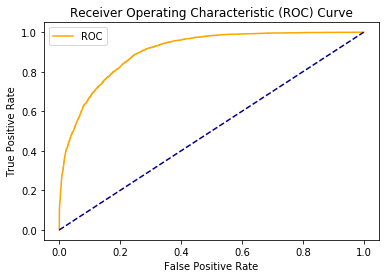

In [109]:
fpr, tpr, thresholds = roc_curve(y_test, probs)
plot_roc_curve(fpr, tpr)  

In [110]:
#print(confusion_matrix(model.predict(data_test),y_test))
#print(classification_report(y_test,model.predict(data_test),digits=4))
print(confusion_matrix(y_test,pred))
print(classification_report(y_test,pred,digits=4))

[[10479   779]
 [ 1512  2154]]
              precision    recall  f1-score   support

           0     0.8739    0.9308    0.9015     11258
           1     0.7344    0.5876    0.6528      3666

    accuracy                         0.8465     14924
   macro avg     0.8042    0.7592    0.7771     14924
weighted avg     0.8396    0.8465    0.8404     14924



Primjetimo kako su i točnost i roc_auc_score sličnih vrijednosti kao i bez PCA, no možda će nam PCA više koristiti kod nekih drugih algoritama.

Prikažimo kumulaciju individualnih komponenata te scatter-plot između nekih od glavnih komponenata.

In [111]:
pca = PCA(.95)
pca.fit(data_train)
comp = pca.n_components_
data_train = pca.transform(data_train)
data_test = pca.transform(data_test)
data_train_pca = pd.DataFrame(data_train, columns=['PC'+str(i) for i in range(1,data_train.shape[1]+1)])
data_train_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24
0,-0.594101,0.142792,0.135286,0.813853,-0.414736,0.097048,0.480360,1.060748,-0.244486,-0.086001,0.178587,-0.281767,-0.020351,-0.014793,0.032119,-0.224822,-0.122900,-0.080863,-0.254837,0.057061,-0.101131,0.300400,-0.293826,0.724701
1,-1.083593,0.221506,0.147289,1.230375,0.020211,0.030062,-1.367711,-0.495544,1.134449,0.785541,-1.085771,-0.520659,0.168512,0.208029,-0.020973,-0.230685,0.290728,0.008486,0.139627,-0.732340,0.246178,0.097505,-0.526654,-0.127037
2,1.434363,0.537257,0.498818,0.201476,-0.235791,0.087674,-0.470780,-0.177854,-0.497238,0.006699,0.274611,0.084124,-0.089702,0.704195,-0.460346,0.011918,-0.039245,0.120935,-0.084209,-0.167231,-0.014509,-0.013211,0.001125,-0.072962
3,2.363244,-1.013332,-3.636398,0.158363,0.316468,3.040412,0.344451,-0.223353,0.937142,-0.261529,0.014834,-0.026497,-0.010362,0.143093,-0.080141,-0.001875,-0.021477,0.187765,0.006115,0.779012,-0.039960,0.024900,-0.320347,-0.115578
4,0.439436,-0.039308,0.151313,0.682179,-0.402606,-0.485318,0.905202,0.826241,0.573951,-0.595314,-0.693601,0.211750,0.864582,0.009006,0.179389,-0.235304,-0.148385,-0.300714,0.319230,-0.667604,0.064110,0.203808,-0.262762,-0.341274


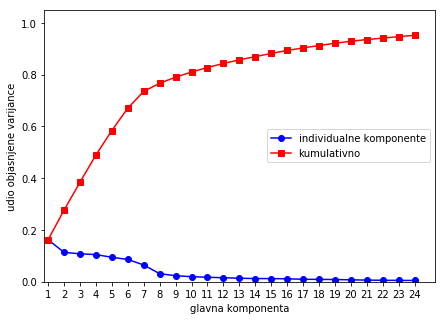

In [112]:
plt.figure(figsize=(7,5))

explained_variance_ratio = pca.explained_variance_ratio_
explained_variance_ratio_cummulative = np.cumsum(pca.explained_variance_ratio_)

plt.plot(range(1,data_train.shape[1]+1), explained_variance_ratio, '-o', label='individualne komponente', c='b')
plt.plot(range(1,data_train.shape[1]+1), explained_variance_ratio_cummulative, '-s', label='kumulativno', c='r')

plt.ylabel('udio objasnjene varijance')
plt.xlabel('glavna komponenta')
plt.xlim(0.75,data_train.shape[1]+1.25)
plt.ylim(0,1.05)
plt.xticks(range(1,data_train.shape[1]+1))
plt.legend(loc='center right')
plt.show()

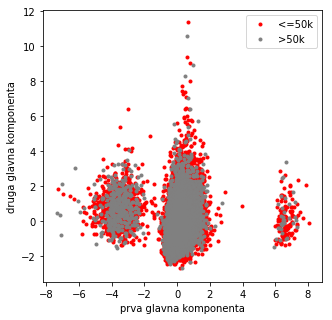

In [113]:
PCA_plot('PC3','PC4')

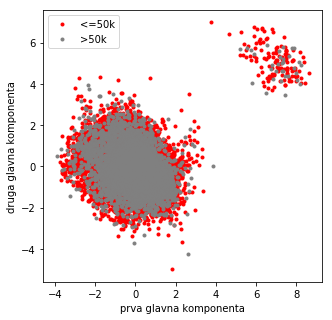

In [114]:
PCA_plot('PC2','PC6')

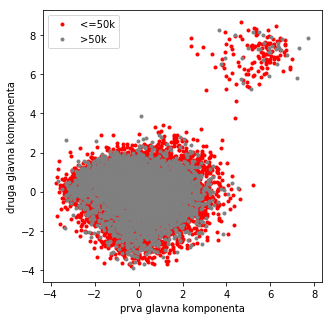

In [115]:
PCA_plot('PC1','PC2')

### Logistic regression (bez PCA)

Provedimo logističku regresiju sa NormalScaler sklairanjem te bez PCA.

In [116]:
data_train, data_test = train_test_split(data_norm_stand, test_size=0.33, random_state=50)
accuracy_Score, auc_score, probs, pred = logistic_regression_no_pca(data_train,data_test,0.8)
print("Accuraccy score: %.4f" % accuracy_Score)
print("AUC: %.4f" % auc_score)

Accuraccy score: 0.8508
AUC: 0.9071


Prikažimo izgled Roc krivulje.

In [0]:
fpr, tpr, thresholds = roc_curve(data_test['Income'], probs) 

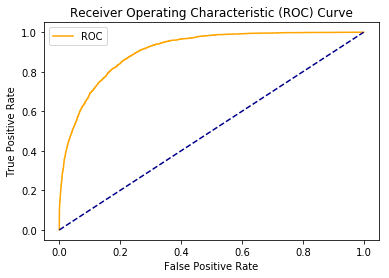

In [118]:
plot_roc_curve(fpr, tpr)  

In [119]:
print(confusion_matrix(data_test['Income'], pred))
print(classification_report(data_test['Income'], pred, digits=4))

[[10475   783]
 [ 1444  2222]]
              precision    recall  f1-score   support

           0     0.8788    0.9304    0.9039     11258
           1     0.7394    0.6061    0.6662      3666

    accuracy                         0.8508     14924
   macro avg     0.8091    0.7683    0.7850     14924
weighted avg     0.8446    0.8508    0.8455     14924



Možemo primjetiti kako bolje rezultate dobivamo bez PCA, slične kao i kod postupka bez skaliranja gdje nismo maknuli "missing values" i one iznose: oko 0.85 točnost te 0.91 roc_auc score.

U nastavku promatramo utječu li promjene parametara na uspješnost algoritama.

### Promjene parametra

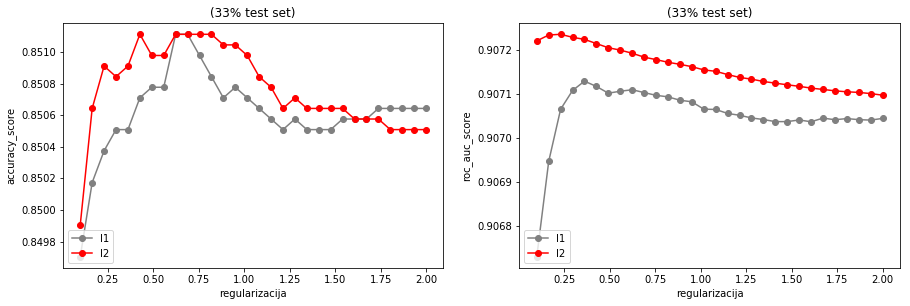

In [120]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4.5))

C_array = np.linspace(0.1,2.0,30)
acc_l1 = []
acc_l2 = []
roc_auc_list1 = []
roc_auc_list2 = []

for c_value in C_array:
    
    data_train, data_test = train_test_split(data_norm_stand, test_size=0.33, random_state=50)
    
    model_l1 = Pipeline([('logistic', LogisticRegression(penalty='l1',C=c_value, solver='liblinear'))])
    model_l2 = Pipeline([('logistic', LogisticRegression(penalty='l2',C=c_value, solver='newton-cg', max_iter=5000))]) 

    model_l1 = model_l1.fit(data_train.drop('Income',axis=1),data_train['Income'])
    model_l2 = model_l2.fit(data_train.drop('Income',axis=1),data_train['Income'])
    
    probs = model_l1.predict_proba(data_test.drop('Income',axis=1))
    probs = probs[:,1]
    roc_auc_l1 = roc_auc_score(data_test['Income'], probs)
    
    probs = model_l2.predict_proba(data_test.drop('Income',axis=1))
    probs = probs[:,1]
    roc_auc_l2 = roc_auc_score(data_test['Income'], probs)

    acc_l1.append(model_l1.score(data_test.drop('Income',axis=1),data_test['Income'])) 
    acc_l2.append(model_l2.score(data_test.drop('Income',axis=1),data_test['Income']))
                  
    roc_auc_list1.append(roc_auc_l1)
    roc_auc_list2.append(roc_auc_l2)
    
ax[0].plot(C_array, acc_l1, '-o', color='gray', label='l1') 
ax[0].plot(C_array, acc_l2, '-o', color='red', label='l2') 
ax[1].plot(C_array, roc_auc_list1, '-o', color='gray', label='l1') 
ax[1].plot(C_array, roc_auc_list2, '-o', color='red', label='l2') 

ax[0].legend(loc='lower left')
ax[1].legend(loc='lower left')

ax[0].set(title='(33% test set)', xlabel='regularizacija',ylabel='accuracy_score')
ax[1].set(title='(33% test set)', xlabel='regularizacija',ylabel='roc_auc_score')

plt.show();

Zaključujemo da promjene parametra ne utječu značajno na uspješnost algoritama. Bez obzira na parametar C te vrstu regularizacije, rezultati se kreću oko sličnih vrijednosti.

Accuracy se kreće oko 0.85 neovisno o vrijednosti parametra C, dok roc_auc vrijednost iznosi približno 0.91.

In [121]:
data_train, data_test = train_test_split(data_norm_stand, test_size=0.33, random_state=50)
accuracy_Score, auc_score, probs, pred = logistic_regression_no_pca(data_train,data_test,1.5)
print("Accuraccy score: %.4f" % accuracy_Score)
print("AUC: %.4f" % auc_score)

Accuraccy score: 0.8506
AUC: 0.9070


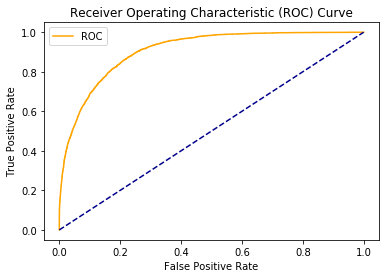

In [122]:
fpr, tpr, thresholds = roc_curve(data_test['Income'], probs)
plot_roc_curve(fpr, tpr)  

In [123]:
print(confusion_matrix(data_test['Income'], pred))
print(classification_report(data_test['Income'], pred, digits=4))

[[10472   786]
 [ 1444  2222]]
              precision    recall  f1-score   support

           0     0.8788    0.9302    0.9038     11258
           1     0.7387    0.6061    0.6659      3666

    accuracy                         0.8506     14924
   macro avg     0.8088    0.7681    0.7848     14924
weighted avg     0.8444    0.8506    0.8453     14924



Algoritam i dalje lošije klasificira pozitivne primjerke.

###  Random forest

Provodimo random forest algoritam s i bez PCA nakon primjene StandardScaler-a.

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

#### Random forest (PCA)

In [0]:
data_train, data_test, y_train, y_test = train_test_split(data_norm_stand.drop("Income",axis=1),data_norm_stand["Income"], test_size=0.33, random_state=50)

In [142]:
acc_score, AUC, components, probs, y_pred, clf = random_forest_pca(data_train, data_test, y_train, y_test)

print("Accuracy: %.4f" % acc_score)
print("AUC: %.4f" % AUC)

Accuracy: 0.8433
AUC: 0.8959


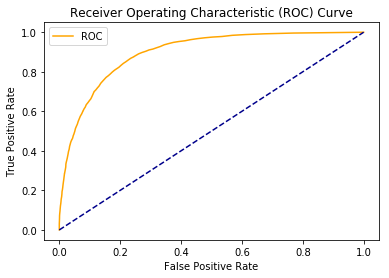

In [143]:
fpr, tpr, thresholds = roc_curve(y_test, probs)
plot_roc_curve(fpr, tpr) 

In [144]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=4))

[[10388   870]
 [ 1468  2198]]
              precision    recall  f1-score   support

           0     0.8762    0.9227    0.8988     11258
           1     0.7164    0.5996    0.6528      3666

    accuracy                         0.8433     14924
   macro avg     0.7963    0.7611    0.7758     14924
weighted avg     0.8369    0.8433    0.8384     14924



#### Random forest (bez PCA)

In [0]:
data_train, data_test,y_train,y_test = train_test_split(data_norm_stand.drop("Income",axis=1),data_norm_stand["Income"],test_size=0.33, random_state=50)

In [146]:
acc_score, AUC, probs, y_pred, clf = random_forest_no_pca(data_train, data_test, y_train, y_test)
print("Accuracy: %.4f" % acc_score)
print("AUC: %.4f" % AUC)

Accuracy: 0.8545
AUC: 0.9051


In [147]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[10430,   828],
       [ 1344,  2322]])

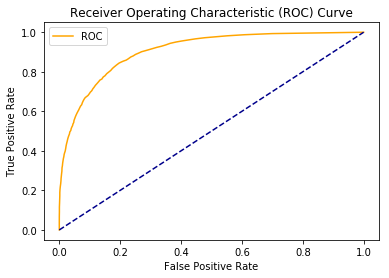

In [148]:
fpr, tpr, thresholds = roc_curve(y_test, probs)
plot_roc_curve(fpr, tpr)

In [149]:
print(confusion_matrix(y_test,pred))
print(classification_report(y_test,pred,digits=4))

[[10472   786]
 [ 1444  2222]]
              precision    recall  f1-score   support

           0     0.8788    0.9302    0.9038     11258
           1     0.7387    0.6061    0.6659      3666

    accuracy                         0.8506     14924
   macro avg     0.8088    0.7681    0.7848     14924
weighted avg     0.8444    0.8506    0.8453     14924



Odabir najboljih svojstva i proveden random forest i logistička regresija samo s tim svojstvima.

In [0]:
feature_imp = pd.Series(clf.feature_importances_,index=data_norm_stand.drop("Income",axis=1).columns).sort_values(ascending=False)


In [0]:
importantfeat=feature_imp[0:50]
keys_imp = importantfeat.keys()
listkeys = keys_imp.tolist()


In [153]:
data4 = data_norm_stand.drop("Income",axis=1)[listkeys]
data4.head()

,fnlwgt,Age,Education-num,Capital-gain,Hours-per-week,column13,column34,Capital-loss,column12,column26,column23,column33,column37,column80,column35,column0,column22,column2,column81,column24,column28,column15,column5,column8,column39,column1,column25,column20,column7,column3,column30,column27,column36,column4,column19,column31,column21,column9,column42,column16,column38,column14,column63,column11,column46,column45,column59,column17,column62,column10
0,0.350889,-1.024983,-1.221559,-0.146733,-0.078120,0.0,0.0,-0.21878,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.945878,-0.041455,-0.438122,-0.146733,0.754701,1.0,1.0,-0.21878,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.393592,-0.798015,0.737034,-0.146733,-0.078120,1.0,1.0,-0.21878,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.278420,0.412481,-0.046403,0.877467,-0.078120,1.0,1.0,-0.21878,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.084802,-0.344079,-1.613277,-0.146733,-0.910942,0.0,0.0,-0.21878,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
X_train, X_test, y_train, y_test = train_test_split(data4, data_norm_stand["Income"], test_size=0.33, random_state=50)

In [155]:
clf=RandomForestClassifier(n_estimators=100)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8564727954971857


In [156]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,clf.predict(X_test))

array([[10458,   800],
       [ 1342,  2324]])

In [157]:
probs = clf.predict_proba(X_test)
probs = probs[:,1]
auc_score = roc_auc_score(y_test, probs)
print("AUC: %.4f" % auc_score)

AUC: 0.9074


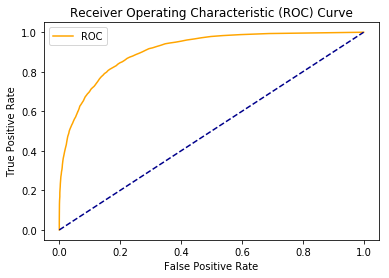

In [158]:
fpr, tpr, thresholds = roc_curve(y_test, probs)
plot_roc_curve(fpr, tpr)

Pokrenimo logističku regresiju samo sa najbitnim svojstvima.

In [159]:
X_train, X_test, y_train, y_test = train_test_split(data4, data_norm_stand["Income"], test_size=0.33, random_state=50)

model = Pipeline([('logistic', LogisticRegression(penalty='l1',C=0.75, solver='liblinear'))]) 
model.fit(X_train,y_train)
accuracy_test = model.score(X_test,y_test) 
print("Accuracy test: ", accuracy_test)
probs = model.predict_proba(X_test)
probs = probs[:,1]
auc_score = roc_auc_score(y_test, probs)
print("AUC: %.4f" % auc_score)

Accuracy test:  0.8512463146609488
AUC: 0.9071


Dobili smo dosad najbolje rezultate i to za Random forest algoritam bez PCA.

###  SVM

Sada ćemo provesti SVM.

In [0]:
from sklearn import svm
from sklearn.model_selection import train_test_split

In [0]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

In [0]:
from sklearn import metrics

In [0]:
data_train, data_test = train_test_split(data_norm_stand,test_size=0.33, random_state=50)

#### Bez PCA

In [164]:
clf = svm.SVC(kernel='linear',C=1, probability=True)
clf.fit(data_train.drop("Income",axis=1), data_train["Income"])

yd_pred = clf.predict(data_test.drop("Income",axis=1))

print("Accuracy:",metrics.accuracy_score(yd_pred, data_test["Income"]))

Accuracy: 0.8492361297239346


In [165]:
probs = clf.predict_proba(data_test.drop('Income',axis=1))
probs = probs[:,1]
auc_score = roc_auc_score(data_test['Income'], probs)
print("AUC: %.4f" % auc_score)

AUC: 0.9047


In [166]:
C_s = [0.1,0.5,1,1.5,2.0,4.0]
for c_ in C_s:
  data_train, data_test = train_test_split(data_norm_stand,test_size=0.33, random_state=50)
  clf = svm.SVC(kernel='linear',C=c_,probability=True)
  clf.fit(data_train.drop("Income",axis=1), data_train["Income"])

  yd_pred = clf.predict(data_test.drop("Income",axis=1))
  
  print("C:",c_)
  print("Accuracy:",metrics.accuracy_score(data_test["Income"], yd_pred))
  probs = clf.predict_proba(data_test.drop('Income',axis=1))
  probs = probs[:,1]
  auc_score = roc_auc_score(data_test['Income'], probs)
  print("AUC: %.4f" % auc_score)
  

C: 0.1
Accuracy: 0.8496381667113374
AUC: 0.9048
C: 0.5
Accuracy: 0.8496381667113374
AUC: 0.9048
C: 1
Accuracy: 0.8492361297239346
AUC: 0.9047
C: 1.5
Accuracy: 0.8495041543822032
AUC: 0.9047
C: 2.0
Accuracy: 0.8493031358885017
AUC: 0.9047
C: 4.0
Accuracy: 0.8493701420530689
AUC: 0.9047


Ako koristimo linear kernel najbolji rezultati iznose oko 0.84937 (točnost) te 0.9048 (roc-auc) i promjenom parametara nema mnogo razlike.

In [167]:
gamma_s = [0.001,0.01,0.1]
C_s = [0.1,0.5,1.0,2.0,4.0]
for c_ in C_s:
  for gamma_ in gamma_s:
    data_train, data_test = train_test_split(data_norm_stand,test_size=0.33, random_state=50)
    clf = svm.SVC(kernel='rbf',C=c_, gamma = gamma_, probability=True)
    clf.fit(data_train.drop("Income",axis=1), data_train["Income"])

    yd_pred = clf.predict(data_test.drop("Income",axis=1))
  
    print("C: %f, gamma: %f"%(c_,gamma_))
    print("Accuracy:",metrics.accuracy_score(data_test["Income"], yd_pred))
    probs = clf.predict_proba(data_test.drop('Income',axis=1))
    probs = probs[:,1]
    auc_score = roc_auc_score(data_test['Income'], probs)
    print("AUC: %.4f" % auc_score)

KeyboardInterrupt: ignored

Najbolje dobiveni rezultat je za C = 2 i gamma = 0.1 pri čemu accuracy iznosi 0.85828, dok vrijednost roc-auc iznosi 0.91 što je među boljim rezultatima.

### SVM(PCA)

Provodimo algoritam SVM koristeći PCA i najbolje  pronađane parametre.

In [0]:
data_train, data_test, y_train, y_test = train_test_split(data_norm_stand.drop("Income",axis=1),data_norm_stand["Income"], test_size=0.33, random_state=50)
pca = PCA(.95)
pca.fit(data_train)
pca.n_components_
data_train = pca.transform(data_train)
data_test = pca.transform(data_test)

In [0]:
clf = svm.SVC(kernel='linear',C=0.3, probability=True)

clf.fit((data_train), y_train)

yd_pred = clf.predict(data_test)

print("Accuracy:",metrics.accuracy_score(y_test, yd_pred))
probs = clf.predict_proba(data_test)
probs = probs[:,1]
auc_score = roc_auc_score(y_test, probs)
print("AUC: %.4f" % auc_score)

Accuracy: 0.8472929509514875
AUC: 0.9005


In [0]:
data_train, data_test, y_train, y_test = train_test_split(data_norm_stand.drop("Income",axis=1),data_norm_stand["Income"], test_size=0.33, random_state=50)
pca = PCA(.95)
pca.fit(data_train)
pca.n_components_
data_train = pca.transform(data_train)
data_test = pca.transform(data_test)

clf = svm.SVC(kernel='rbf',C=2, gamma = 0.1, probability=True)
#Train the model using the training sets
clf.fit((data_train), y_train)

#Predict the response for test dataset
yd_pred = clf.predict(data_test)

print("Accuracy:",metrics.accuracy_score(y_test,yd_pred))
probs = clf.predict_proba(data_test)
probs = probs[:,1]
auc_score = roc_auc_score(y_test, probs)
print("AUC: %.4f" % auc_score)

Accuracy: 0.8545966228893058
AUC: 0.8921


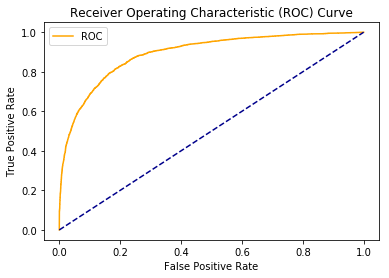

[[10611   647]
 [ 1523  2143]]
              precision    recall  f1-score   support

           0     0.8745    0.9425    0.9072     11258
           1     0.7681    0.5846    0.6639      3666

    accuracy                         0.8546     14924
   macro avg     0.8213    0.7635    0.7856     14924
weighted avg     0.8484    0.8546    0.8475     14924



In [0]:
fpr, tpr, thresholds = roc_curve(y_test, probs)
plot_roc_curve(fpr, tpr)
print(confusion_matrix(y_test,yd_pred))
print(classification_report(y_test,yd_pred,digits=4))

### KNN algoritam

#### KNN algoritam bez PCA

In [0]:
data_train, data_test, y_train, y_test = train_test_split(data_norm_stand.drop("Income",axis=1),data_norm_stand["Income"], test_size=0.33, random_state=50)

In [169]:
score_knn, auc_score, probs, y_pred = knn_no_pca(data_train,data_test,y_train,y_test,5)
print('The accuracy of the KNN Model is',score_knn)
print("AUC: %.4f" % auc_score)

The accuracy of the KNN Model is 0.8362369337979094
AUC: 0.8669


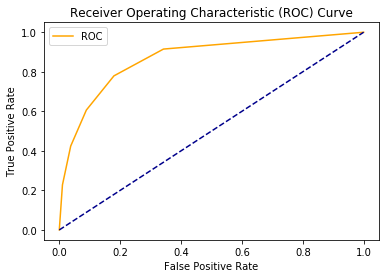

[[10257  1001]
 [ 1443  2223]]
              precision    recall  f1-score   support

           0     0.8767    0.9111    0.8935     11258
           1     0.6895    0.6064    0.6453      3666

    accuracy                         0.8362     14924
   macro avg     0.7831    0.7587    0.7694     14924
weighted avg     0.8307    0.8362    0.8326     14924



In [170]:
fpr, tpr, thresholds = roc_curve(y_test, probs)
plot_roc_curve(fpr, tpr)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred,digits=4))

In [171]:
score_knn, auc_score, probs, y_pred = knn_no_pca(data_train,data_test,y_train,y_test,5,'distance',1)
print('The accuracy of the KNN Model is',score_knn)
print("AUC: %.4f" % auc_score)

The accuracy of the KNN Model is 0.8302733851514339
AUC: 0.8611


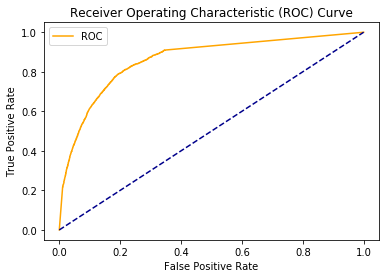

[[10190  1068]
 [ 1465  2201]]
              precision    recall  f1-score   support

           0     0.8743    0.9051    0.8895     11258
           1     0.6733    0.6004    0.6348      3666

    accuracy                         0.8303     14924
   macro avg     0.7738    0.7528    0.7621     14924
weighted avg     0.8249    0.8303    0.8269     14924



In [172]:
fpr, tpr, thresholds = roc_curve(y_test, probs)
plot_roc_curve(fpr, tpr)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred,digits=4))

Bez obzira na promjenu parametara KNN algoritam daje iste rezultate.

#### KNN algoritam (PCA)

The accuracy of the KNN Model is 0.8341597426963281
AUC: 0.8642
PCA Components 24


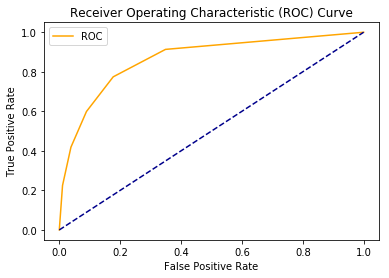

[[10253  1005]
 [ 1470  2196]]
              precision    recall  f1-score   support

           0     0.8746    0.9107    0.8923     11258
           1     0.6860    0.5990    0.6396      3666

    accuracy                         0.8342     14924
   macro avg     0.7803    0.7549    0.7659     14924
weighted avg     0.8283    0.8342    0.8302     14924



In [173]:
data_train, data_test, y_train, y_test = train_test_split(data_norm_stand.drop("Income",axis=1),data_norm_stand["Income"], test_size=0.33, random_state=50)
score_knn, auc_score,comp, probs, y_pred = knn_pca(data_train,data_test,y_train,y_test,5)
print('The accuracy of the KNN Model is',score_knn)
print("AUC: %.4f" % auc_score)
print("PCA Components",components)
fpr, tpr, thresholds = roc_curve(y_test, probs)
plot_roc_curve(fpr, tpr)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred,digits=4))

The accuracy of the KNN Model is 0.8287322433663897
AUC: 0.8622
PCA Components 24


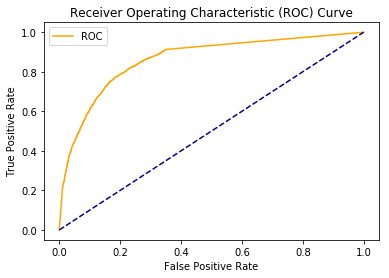

[[10189  1069]
 [ 1487  2179]]
              precision    recall  f1-score   support

           0     0.8726    0.9050    0.8885     11258
           1     0.6709    0.5944    0.6303      3666

    accuracy                         0.8287     14924
   macro avg     0.7718    0.7497    0.7594     14924
weighted avg     0.8231    0.8287    0.8251     14924



In [174]:
data_train, data_test, y_train, y_test = train_test_split(data_norm_stand.drop("Income",axis=1),data_norm_stand["Income"], test_size=0.33, random_state=50)
score_knn, auc_score,comp, probs, y_pred = knn_pca(data_train,data_test,y_train,y_test,5,'distance',1)
print('The accuracy of the KNN Model is',score_knn)
print("AUC: %.4f" % auc_score)
print("PCA Components",components)
fpr, tpr, thresholds = roc_curve(y_test, probs)
plot_roc_curve(fpr, tpr)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred,digits=4))

### Naive Bayes

#### Naive Bayes (bez PCA)

In [175]:
data_train, data_test = train_test_split(data_norm_stand, test_size=0.33, random_state=50)
gaussian_pf = GaussianNB()
gaussian_pf.partial_fit(data_train.drop('Income',axis=1),data_train['Income'], np.unique(data_train['Income']))
score_gaussian_pf = gaussian_pf.score(data_test.drop('Income',axis=1),data_test['Income'])
print('The accuracy of partial Gaussian Naive Bayes is', score_gaussian_pf)
probs = gaussian_pf.predict_proba(data_test.drop('Income',axis=1))
probs = probs[:,1]
auc_score = roc_auc_score(data_test['Income'], probs)
print("AUC: %.4f" % auc_score)

The accuracy of partial Gaussian Naive Bayes is 0.6234923612972394
AUC: 0.8586


#### Naive-Bayes (PCA)

In [0]:
data_train, data_test, y_train, y_test = train_test_split(data_norm_stand.drop("Income",axis=1),data_norm_stand["Income"], test_size=0.33, random_state=50)
pca = PCA(.95)
pca.fit(data_train)
pca.n_components_
data_train = pca.transform(data_train)
data_test = pca.transform(data_test)

In [177]:
gaussian_pf = GaussianNB()
gaussian_pf.partial_fit(data_train, y_train, np.unique(y_train))
score_gaussian_pf = gaussian_pf.score(data_test,y_test)
print('The accuracy of partial Gaussian Naive Bayes is', score_gaussian_pf)
probs = gaussian_pf.predict_proba(data_test)
probs = probs[:,1]
auc_score = roc_auc_score(y_test, probs)
print("AUC: %.4f" % auc_score)

The accuracy of partial Gaussian Naive Bayes is 0.792079871348164
AUC: 0.8344


In [178]:
gaussian = GaussianNB()
gaussian.fit(data_train,y_train)
score_gaussian = gaussian.score(data_test,y_test)
print('The accuracy of Gaussian Naive Bayes is', score_gaussian)
probs = gaussian.predict_proba(data_test)
probs = probs[:,1]
auc_score = roc_auc_score(y_test, probs)
print("AUC: %.4f" % auc_score)

The accuracy of Gaussian Naive Bayes is 0.792079871348164
AUC: 0.8344


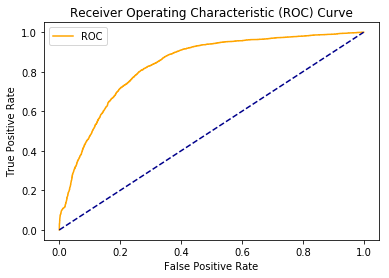

[[10189  1069]
 [ 1487  2179]]
              precision    recall  f1-score   support

           0     0.8726    0.9050    0.8885     11258
           1     0.6709    0.5944    0.6303      3666

    accuracy                         0.8287     14924
   macro avg     0.7718    0.7497    0.7594     14924
weighted avg     0.8231    0.8287    0.8251     14924



In [179]:
pred = gaussian.predict(data_test)
fpr, tpr, thresholds = roc_curve(y_test, probs)
plot_roc_curve(fpr, tpr)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred,digits=4))

### Neuronske mreze

Nakon skaliranja podataka očekujemo da ćemo dobiti bolje rezultate. Nakon provedbe algoritama neuronskih mreža dobivamo točnost oko 0.85 te roc_auc vrijednost 0.9127 što je najbolja takva vrijednost koju smo uspjeli dobiti. 

In [0]:
X_train, X_test,y_train, y_test = train_test_split(data_norm_stand.drop("Income",axis=1),data_norm_stand["Income"], test_size=0.33, random_state=100)

In [181]:
mlp = MLPClassifier(hidden_layer_sizes=(13,13,13),max_iter=500, random_state=1)
mlp.fit(X_train,y_train)
predictions = mlp.predict(X_test)
from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions,digits=4))
probs = mlp.predict_proba(X_test)
probs = probs[:,1]
auc_score = roc_auc_score(y_test, probs)
print("AUC: %.4f" % auc_score)

[[10446   796]
 [ 1436  2246]]
              precision    recall  f1-score   support

           0     0.8791    0.9292    0.9035     11242
           1     0.7383    0.6100    0.6681      3682

    accuracy                         0.8504     14924
   macro avg     0.8087    0.7696    0.7858     14924
weighted avg     0.8444    0.8504    0.8454     14924

AUC: 0.9070


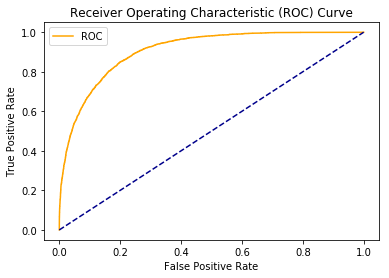

In [182]:
fpr, tpr, thresholds = roc_curve(y_test, probs)
plot_roc_curve(fpr, tpr)

In [183]:
from sklearn.neural_network import MLPClassifier  
mlp = MLPClassifier(hidden_layer_sizes=(10, 10, 10), max_iter=1000, random_state=1)  
mlp.fit(X_train, y_train.values.ravel()) 
predictions = mlp.predict(X_test)
from sklearn.metrics import classification_report, confusion_matrix  
print(confusion_matrix(y_test,predictions))  
print(classification_report(y_test,predictions,digits=4))
probs = mlp.predict_proba(X_test)
probs = probs[:,1]
auc_score = roc_auc_score(y_test, probs)
print("AUC: %.4f" % auc_score)

[[10493   749]
 [ 1498  2184]]
              precision    recall  f1-score   support

           0     0.8751    0.9334    0.9033     11242
           1     0.7446    0.5932    0.6603      3682

    accuracy                         0.8494     14924
   macro avg     0.8099    0.7633    0.7818     14924
weighted avg     0.8429    0.8494    0.8433     14924

AUC: 0.9084


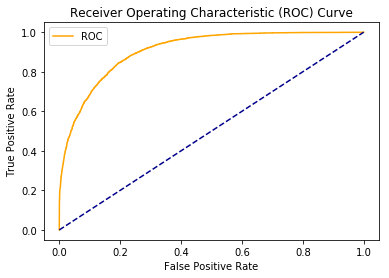

In [184]:
fpr, tpr, thresholds = roc_curve(y_test, probs)
plot_roc_curve(fpr, tpr)

In [185]:
from sklearn.neural_network import MLPClassifier  
mlp = MLPClassifier(hidden_layer_sizes=(13, 13, 13, 13), max_iter=1000, random_state=1)  
mlp.fit(X_train, y_train.values.ravel()) 
predictions = mlp.predict(X_test)
from sklearn.metrics import classification_report, confusion_matrix  
print(confusion_matrix(y_test,predictions))  
print(classification_report(y_test,predictions,digits=4))
probs = mlp.predict_proba(X_test)
probs = probs[:,1]
auc_score = roc_auc_score(y_test, probs)
print("AUC: %.4f" % auc_score)

[[10491   751]
 [ 1476  2206]]
              precision    recall  f1-score   support

           0     0.8767    0.9332    0.9040     11242
           1     0.7460    0.5991    0.6646      3682

    accuracy                         0.8508     14924
   macro avg     0.8113    0.7662    0.7843     14924
weighted avg     0.8444    0.8508    0.8450     14924

AUC: 0.9054


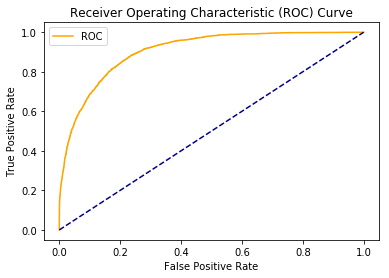

In [186]:
fpr, tpr, thresholds = roc_curve(y_test, probs)
plot_roc_curve(fpr, tpr)

In [187]:
from sklearn.neural_network import MLPClassifier  
mlp = MLPClassifier(hidden_layer_sizes=(13, 13, 13), max_iter=500, random_state=1, solver='sgd')  
mlp.fit(X_train, y_train.values.ravel()) 
predictions = mlp.predict(X_test)
from sklearn.metrics import classification_report, confusion_matrix  
print(confusion_matrix(y_test,predictions))  
print(classification_report(y_test,predictions,digits=4))
probs = mlp.predict_proba(X_test)
probs = probs[:,1]
auc_score = roc_auc_score(y_test, probs)
print("AUC: %.4f" % auc_score)

[[10502   740]
 [ 1415  2267]]
              precision    recall  f1-score   support

           0     0.8813    0.9342    0.9069     11242
           1     0.7539    0.6157    0.6778      3682

    accuracy                         0.8556     14924
   macro avg     0.8176    0.7749    0.7924     14924
weighted avg     0.8498    0.8556    0.8504     14924

AUC: 0.9127


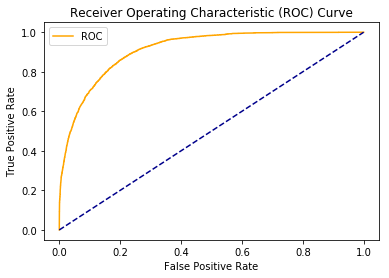

In [188]:
fpr, tpr, thresholds = roc_curve(y_test, probs)
plot_roc_curve(fpr, tpr)

## Uređivanje podataka - RobustScaler

Nadalje, pokušat ćemo testirati iste algoritme primjenjujući RobustScaling i MinMaxScaling na podacima. No, rezultati koje dobivamo su za većinu algoritama slični (razlikuju se za manje od 0.02) dok smo za samo neke dobili poboljšanja.

### Transformacija podataka

In [0]:
from sklearn.preprocessing import RobustScaler

In [0]:
robust_frame = RobustScaler().fit_transform(data_noNaN[["Age","fnlwgt","Capital-gain","Capital-loss","Hours-per-week","Education-num"]])
robust_age = robust_frame[:,0]
robust_fnlwgt = robust_frame[:,1]
robust_gain = robust_frame[:,2]
robust_loss = robust_frame[:,3]
robust_hours = robust_frame[:,4]
robust_edu = robust_frame[:,5]

In [191]:

robust_stand = data_noNaN[['Workclass','Race','Marital-status','Occupation','Relationship','Native-country','Sex']]
robust_stand["Age"] = robust_age
robust_stand["fnlwgt"] = robust_fnlwgt
robust_stand["Capital-gain"] = robust_gain
robust_stand["Capital-loss"] = robust_loss
robust_stand["Hours-per-week"] = robust_hours
robust_stand["Education-num"] = robust_edu

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

In [192]:
robust_stand=robust_stand[["Age","fnlwgt","Capital-gain","Capital-loss","Hours-per-week","Education-num"]]
from sklearn.preprocessing import OneHotEncoder
data_noNaN2 = data_noNaN[['Workclass','Race','Marital-status','Occupation','Relationship','Native-country','Sex']]
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
data_ohe_noNaN = ohe.fit_transform(data_noNaN2)

for i in range(0,82):
    columni="column"+str(i)
    robust_stand[columni] = data_ohe_noNaN[:,i]
    
robust_stand["Income"] = data_noNaN["Income"]
robust_stand.head(10)

,Age,fnlwgt,Capital-gain,Capital-loss,Hours-per-week,Education-num,column0,column1,column2,column3,column4,column5,column6,column7,column8,column9,column10,column11,column12,column13,column14,column15,column16,column17,column18,column19,column20,column21,column22,column23,column24,column25,column26,column27,column28,column29,column30,column31,column32,column33,...,column43,column44,column45,column46,column47,column48,column49,column50,column51,column52,column53,column54,column55,column56,column57,column58,column59,column60,column61,column62,column63,column64,column65,column66,column67,column68,column69,column70,column71,column72,column73,column74,column75,column76,column77,column78,column79,column80,column81,Income
0,-0.631579,0.402247,0.0,0.0,0.0,-0.75,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
1,0.052632,-0.734226,0.0,0.0,2.0,-0.25,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
2,-0.473684,1.316061,0.0,0.0,0.0,0.50,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
3,0.368421,-0.149273,7688.0,0.0,0.0,0.00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
4,-0.157895,0.169051,0.0,0.0,-2.0,-1.00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
5,1.368421,-0.611344,3103.0,0.0,-1.6,1.25,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
6,-0.684211,1.587478,0.0,0.0,0.0,0.00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
7,0.947368,-0.608274,0.0,0.0,-6.0,-1.50,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
8,1.473684,0.050922,6418.0,0.0,0.0,-0.25,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
9,-0.052632,0.283305,0.0,0.0,0.0,0.75,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

### Log Reg

#### Log Reg (bez PCA)

Accuraccy score: 0.8509
AUC: 0.9071


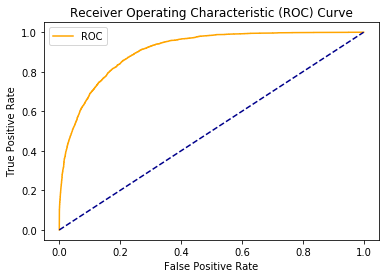

[[10475   783]
 [ 1442  2224]]
              precision    recall  f1-score   support

           0     0.8790    0.9304    0.9040     11258
           1     0.7396    0.6067    0.6666      3666

    accuracy                         0.8509     14924
   macro avg     0.8093    0.7686    0.7853     14924
weighted avg     0.8448    0.8509    0.8457     14924



In [193]:
data_train, data_test = train_test_split(robust_stand, test_size=0.33, random_state=50)
accuracy_Score, auc_score, probs, pred = logistic_regression_no_pca(data_train,data_test,0.8)
print("Accuraccy score: %.4f" % accuracy_Score)
print("AUC: %.4f" % auc_score)
fpr, tpr, thresholds = roc_curve(data_test["Income"], probs)
plot_roc_curve(fpr, tpr)
print(confusion_matrix(data_test["Income"],pred))
print(classification_report(data_test["Income"],pred,digits=4))

#### Log Reg (PCA)

In [194]:
data_train, data_test, y_train, y_test = train_test_split(robust_stand.drop("Income",axis=1),robust_stand["Income"], test_size=0.33, random_state=50)
accuracy_Score, auc_score, components, probs, pred = logistic_regression_pca(data_train, data_test, y_train, y_test, 0.8)
print("Accuraccy score: %.4f" % accuracy_Score)
print("AUC: %.4f" % auc_score)
print("Broj komponenti (95% objašnjene varijance):",components)

Accuraccy score: 0.7921
AUC: 0.7228
Broj komponenti (95% objašnjene varijance): 1


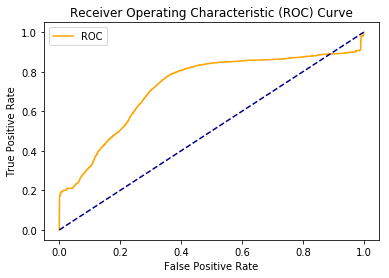

[[11088   170]
 [ 2932   734]]
              precision    recall  f1-score   support

           0     0.7909    0.9849    0.8773     11258
           1     0.8119    0.2002    0.3212      3666

    accuracy                         0.7921     14924
   macro avg     0.8014    0.5926    0.5993     14924
weighted avg     0.7960    0.7921    0.7407     14924



In [195]:
fpr, tpr, thresholds = roc_curve(y_test, probs)
plot_roc_curve(fpr, tpr)
print(confusion_matrix(y_test,pred))
print(classification_report(y_test,pred,digits=4))

### Random Forest

#### Random Forest (bez PCA)

In [196]:
data_train, data_test = train_test_split(robust_stand,test_size=0.33, random_state=50)
clf=RandomForestClassifier(n_estimators=100)

clf.fit(data_train.drop("Income",axis=1),data_train["Income"])

y_pred=clf.predict(data_test.drop("Income",axis=1))

print("Accuracy:",metrics.accuracy_score(data_test["Income"], y_pred))
probs = clf.predict_proba(data_test.drop('Income',axis=1))
probs = probs[:,1]
auc_score = roc_auc_score(data_test['Income'], probs)
print("AUC: %.4f" % auc_score)

Accuracy: 0.8572098633074243
AUC: 0.9066


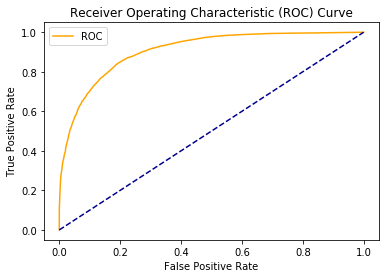

[[10451   807]
 [ 1324  2342]]
              precision    recall  f1-score   support

           0     0.8876    0.9283    0.9075     11258
           1     0.7437    0.6388    0.6873      3666

    accuracy                         0.8572     14924
   macro avg     0.8156    0.7836    0.7974     14924
weighted avg     0.8522    0.8572    0.8534     14924



In [197]:
fpr, tpr, thresholds = roc_curve(data_test['Income'], probs)
plot_roc_curve(fpr, tpr)
print(confusion_matrix(data_test['Income'],y_pred))
print(classification_report(data_test['Income'],y_pred,digits=4))

In [0]:
feature_imp = pd.Series(clf.feature_importances_,index=robust_stand.drop("Income",axis=1).columns).sort_values(ascending=False)
importantfeat=feature_imp[0:50]
keys_imp = importantfeat.keys()
listkeys = keys_imp.tolist()
data4 = robust_stand.drop("Income",axis=1)[listkeys]


In [199]:
X_train, X_test, y_train, y_test = train_test_split(data4, robust_stand["Income"], test_size=0.33, random_state=50)
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
probs = clf.predict_proba(X_test)
probs = probs[:,1]
auc_score = roc_auc_score(y_test, probs)
print("AUC: %.4f" % auc_score)

Accuracy: 0.8540605735727687
AUC: 0.9062


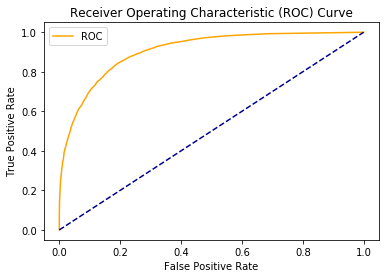

[[10428   830]
 [ 1348  2318]]
              precision    recall  f1-score   support

           0     0.8855    0.9263    0.9054     11258
           1     0.7363    0.6323    0.6804      3666

    accuracy                         0.8541     14924
   macro avg     0.8109    0.7793    0.7929     14924
weighted avg     0.8489    0.8541    0.8502     14924



In [200]:
fpr, tpr, thresholds = roc_curve(y_test, probs)
plot_roc_curve(fpr, tpr)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred,digits=4))

### KNN algoritam

Kod KNN algoritma imamo poboljšanje u odnosu na prethodna izvršavanja.

#### KNN algoritam bez PCA

In [201]:
data_train, data_test = train_test_split(robust_stand, test_size=0.33, random_state=50)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(data_train.drop('Income',axis=1),data_train['Income'])
score_knn = knn.score(data_test.drop('Income',axis=1),data_test['Income'])
print('The accuracy of the KNN Model is',score_knn)
probs = knn.predict_proba(data_test.drop('Income',axis=1))
probs = probs[:,1]
auc_score = roc_auc_score(data_test['Income'], probs)
print("AUC: %.4f" % auc_score)

The accuracy of the KNN Model is 0.854194585901903
AUC: 0.8903


In [202]:
knn = KNeighborsClassifier(n_neighbors=5, weights='distance', p=1)
knn.fit(data_train.drop('Income',axis=1),data_train['Income'])
score_knn = knn.score(data_test.drop('Income',axis=1),data_test['Income'])
print('The accuracy of the KNN Model is',score_knn)
probs = knn.predict_proba(data_test.drop('Income',axis=1))
probs = probs[:,1]
auc_score = roc_auc_score(data_test['Income'], probs)
print("AUC: %.4f" % auc_score)

The accuracy of the KNN Model is 0.8524524256231574
AUC: 0.8894


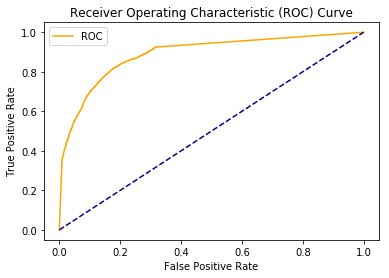

[[10428   830]
 [ 1348  2318]]
              precision    recall  f1-score   support

           0     0.8855    0.9263    0.9054     11258
           1     0.7363    0.6323    0.6804      3666

    accuracy                         0.8541     14924
   macro avg     0.8109    0.7793    0.7929     14924
weighted avg     0.8489    0.8541    0.8502     14924



In [203]:
fpr, tpr, thresholds = roc_curve(data_test['Income'], probs)
plot_roc_curve(fpr, tpr)
print(confusion_matrix(data_test['Income'],y_pred))
print(classification_report(data_test['Income'],y_pred,digits=4))

#### KNN algoritam (PCA)

In [0]:
data_train, data_test, y_train, y_test = train_test_split(robust_stand.drop("Income",axis=1),robust_stand["Income"], test_size=0.33, random_state=50)
pca = PCA(.95)
pca.fit(data_train)
pca.n_components_
data_train = pca.transform(data_train)
data_test = pca.transform(data_test)

In [205]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(data_train, y_train)
score_knn = knn.score(data_test,y_test)
print('The accuracy of the KNN Model is',score_knn)
probs = knn.predict_proba(data_test)
probs = probs[:,1]
auc_score = roc_auc_score(y_test, probs)
print("AUC: %.4f" % auc_score)

The accuracy of the KNN Model is 0.8055481104261593
AUC: 0.8034


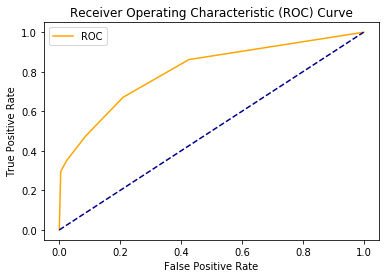

[[10428   830]
 [ 1348  2318]]
              precision    recall  f1-score   support

           0     0.8855    0.9263    0.9054     11258
           1     0.7363    0.6323    0.6804      3666

    accuracy                         0.8541     14924
   macro avg     0.8109    0.7793    0.7929     14924
weighted avg     0.8489    0.8541    0.8502     14924



In [206]:
fpr, tpr, thresholds = roc_curve(y_test, probs)
plot_roc_curve(fpr, tpr)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred,digits=4))

In [207]:
knn = KNeighborsClassifier(n_neighbors=5, weights='distance', p=1)
knn.fit(data_train, y_train)
score_knn = knn.score(data_test,y_test)
print('The accuracy of the KNN Model is',score_knn)
probs = knn.predict_proba(data_test)
probs = probs[:,1]
auc_score = roc_auc_score(y_test, probs)
print("AUC: %.4f" % auc_score)

The accuracy of the KNN Model is 0.7840391316001072
AUC: 0.7939


### Naive Bayes

#### Naive Bayes (bez PCA)

In [208]:
data_train, data_test = train_test_split(robust_stand, test_size=0.33, random_state=50)
gaussian_pf = GaussianNB()
gaussian_pf.partial_fit(data_train.drop('Income',axis=1),data_train['Income'], np.unique(data_train['Income']))
score_gaussian_pf = gaussian_pf.score(data_test.drop('Income',axis=1),data_test['Income'])
print('The accuracy of partial Gaussian Naive Bayes is', score_gaussian_pf)
probs = gaussian_pf.predict_proba(data_test.drop('Income',axis=1))
probs = probs[:,1]
auc_score = roc_auc_score(data_test['Income'], probs)
print("AUC: %.4f" % auc_score)

The accuracy of partial Gaussian Naive Bayes is 0.790605735727687
AUC: 0.8869


In [209]:
gaussian = GaussianNB()
gaussian.fit(data_train.drop('Income',axis=1),data_train['Income'])
score_gaussian = gaussian.score(data_test.drop('Income',axis=1),data_test['Income'])
print('The accuracy of Gaussian Naive Bayes is', score_gaussian)
probs = gaussian.predict_proba(data_test.drop('Income',axis=1))
probs = probs[:,1]
auc_score = roc_auc_score(data_test['Income'], probs)
print("AUC: %.4f" % auc_score)

The accuracy of Gaussian Naive Bayes is 0.790605735727687
AUC: 0.8869


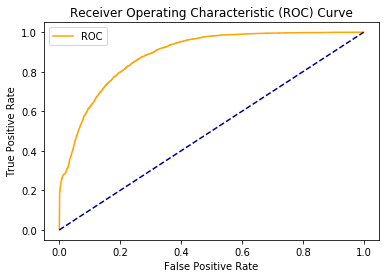

[[10428   830]
 [ 1348  2318]]
              precision    recall  f1-score   support

           0     0.8855    0.9263    0.9054     11258
           1     0.7363    0.6323    0.6804      3666

    accuracy                         0.8541     14924
   macro avg     0.8109    0.7793    0.7929     14924
weighted avg     0.8489    0.8541    0.8502     14924



In [210]:
fpr, tpr, thresholds = roc_curve(data_test['Income'], probs)
plot_roc_curve(fpr, tpr)
print(confusion_matrix(data_test['Income'],y_pred))
print(classification_report(data_test['Income'],y_pred,digits=4))

#### Naive-Bayes (PCA)

In [0]:
data_train, data_test, y_train, y_test = train_test_split(robust_stand.drop("Income",axis=1),robust_stand["Income"], test_size=0.33, random_state=50)
pca = PCA(.95)
pca.fit(data_train)
pca.n_components_
data_train = pca.transform(data_train)
data_test = pca.transform(data_test)

In [212]:
gaussian_pf = GaussianNB()
gaussian_pf.partial_fit(data_train, y_train, np.unique(y_train))
score_gaussian_pf = gaussian_pf.score(data_test,y_test)
print('The accuracy of partial Gaussian Naive Bayes is', score_gaussian_pf)
probs = gaussian_pf.predict_proba(data_test)
probs = probs[:,1]
auc_score = roc_auc_score(y_test, probs)
print("AUC: %.4f" % auc_score)

The accuracy of partial Gaussian Naive Bayes is 0.7856472795497186
AUC: 0.4533


In [213]:
gaussian = GaussianNB()
gaussian.fit(data_train,y_train)
score_gaussian = gaussian.score(data_test,y_test)
print('The accuracy of Gaussian Naive Bayes is', score_gaussian)
probs = gaussian.predict_proba(data_test)
probs = probs[:,1]
auc_score = roc_auc_score(y_test, probs)
print("AUC: %.4f" % auc_score)

The accuracy of Gaussian Naive Bayes is 0.7856472795497186
AUC: 0.4533


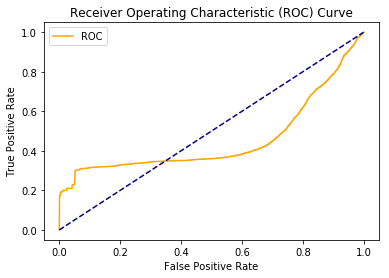

[[10428   830]
 [ 1348  2318]]
              precision    recall  f1-score   support

           0     0.8855    0.9263    0.9054     11258
           1     0.7363    0.6323    0.6804      3666

    accuracy                         0.8541     14924
   macro avg     0.8109    0.7793    0.7929     14924
weighted avg     0.8489    0.8541    0.8502     14924



In [214]:
fpr, tpr, thresholds = roc_curve(y_test, probs)
plot_roc_curve(fpr, tpr)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred,digits=4))

### Neuronske mreze

In [0]:
X_train, X_test,y_train, y_test = train_test_split(robust_stand.drop("Income",axis=1),robust_stand["Income"], test_size=0.33, random_state=50)

In [216]:
from sklearn.neural_network import MLPClassifier  
mlp = MLPClassifier(hidden_layer_sizes=(10, 10, 10), max_iter=1000, random_state=1)  
mlp.fit(X_train, y_train.values.ravel()) 
predictions = mlp.predict(X_test)
from sklearn.metrics import classification_report, confusion_matrix  
print(confusion_matrix(y_test,predictions))  
print(classification_report(y_test,predictions,digits=4))
probs = mlp.predict_proba(X_test)
probs = probs[:,1]
auc_score = roc_auc_score(y_test, probs)
print("AUC: %.4f" % auc_score)

[[10552   706]
 [ 1474  2192]]
              precision    recall  f1-score   support

           0     0.8774    0.9373    0.9064     11258
           1     0.7564    0.5979    0.6679      3666

    accuracy                         0.8539     14924
   macro avg     0.8169    0.7676    0.7871     14924
weighted avg     0.8477    0.8539    0.8478     14924

AUC: 0.9121


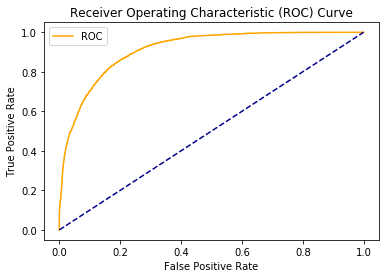

In [217]:
fpr, tpr, thresholds = roc_curve(y_test, probs)
plot_roc_curve(fpr, tpr)

In [218]:
from sklearn.neural_network import MLPClassifier  
mlp = MLPClassifier(hidden_layer_sizes=(13, 13, 13, 13), max_iter=1000, random_state=1)  
mlp.fit(X_train, y_train.values.ravel())
predictions = mlp.predict(X_test)
from sklearn.metrics import classification_report, confusion_matrix  
print(confusion_matrix(y_test,predictions))  
print(classification_report(y_test,predictions,digits=4))
probs = mlp.predict_proba(X_test)
probs = probs[:,1]
auc_score = roc_auc_score(y_test, probs)
print("AUC: %.4f" % auc_score)

[[10370   888]
 [ 1447  2219]]
              precision    recall  f1-score   support

           0     0.8775    0.9211    0.8988     11258
           1     0.7142    0.6053    0.6552      3666

    accuracy                         0.8435     14924
   macro avg     0.7959    0.7632    0.7770     14924
weighted avg     0.8374    0.8435    0.8390     14924

AUC: 0.9003


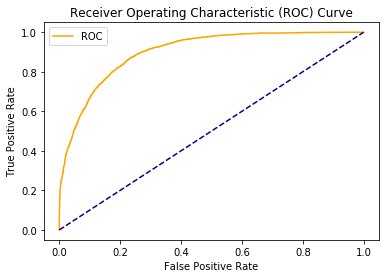

In [219]:
fpr, tpr, thresholds = roc_curve(y_test, probs)
plot_roc_curve(fpr, tpr)

In [220]:
from sklearn.neural_network import MLPClassifier  
mlp = MLPClassifier(hidden_layer_sizes=(13, 13, 13), max_iter=500, random_state=1, solver='sgd')  
mlp.fit(X_train, y_train.values.ravel()) 
predictions = mlp.predict(X_test)
from sklearn.metrics import classification_report, confusion_matrix  
print(confusion_matrix(y_test,predictions))  
print(classification_report(y_test,predictions,digits=4))
probs = mlp.predict_proba(X_test)
probs = probs[:,1]
auc_score = roc_auc_score(y_test, probs)
print("AUC: %.4f" % auc_score)

[[9851 1407]
 [1304 2362]]
              precision    recall  f1-score   support

           0     0.8831    0.8750    0.8790     11258
           1     0.6267    0.6443    0.6354      3666

    accuracy                         0.8183     14924
   macro avg     0.7549    0.7597    0.7572     14924
weighted avg     0.8201    0.8183    0.8192     14924

AUC: 0.8812


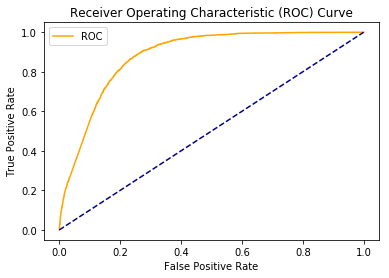

In [221]:
fpr, tpr, thresholds = roc_curve(y_test, probs)
plot_roc_curve(fpr, tpr)

## Uređivanje podataka - MinMaxScaler

### Transformacija podataka

In [0]:
from sklearn.preprocessing import MinMaxScaler

In [0]:
minmax_frame = MinMaxScaler().fit_transform(data_noNaN[["Age","fnlwgt","Capital-gain","Capital-loss","Hours-per-week","Education-num"]])
minmax_age = minmax_frame[:,0]
minmax_fnlwgt = minmax_frame[:,1]
minmax_gain = minmax_frame[:,2]
minmax_loss = minmax_frame[:,3]
minmax_hours = minmax_frame[:,4]
minmax_edu = minmax_frame[:,5]

In [224]:
minmax_stand = data_noNaN[['Workclass','Race','Marital-status','Occupation','Relationship','Native-country','Sex']]
minmax_stand["Age"] = minmax_age
minmax_stand["fnlwgt"] = minmax_fnlwgt
minmax_stand["Capital-gain"] = minmax_gain
minmax_stand["Capital-loss"] = minmax_loss
minmax_stand["Hours-per-week"] = minmax_hours
minmax_stand["Education-num"] = minmax_edu
minmax_stand.head(5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

,Workclass,Race,Marital-status,Occupation,Relationship,Native-country,Sex,Age,fnlwgt,Capital-gain,Capital-loss,Hours-per-week,Education-num
0,0,0,0,0,0,0,0,0.109589,0.144430,0.000000,0.0,0.397959,0.400000
1,0,1,1,1,1,0,0,0.287671,0.051677,0.000000,0.0,0.500000,0.533333
2,1,1,1,2,1,0,0,0.150685,0.219011,0.000000,0.0,0.397959,0.733333
3,0,0,1,0,1,0,0,0.369863,0.099418,0.076881,0.0,0.397959,0.600000
4,0,1,0,3,2,0,0,0.232877,0.125398,0.000000,0.0,0.295918,0.333333


In [225]:
minmax_stand = minmax_stand[["Age","fnlwgt","Capital-gain","Capital-loss","Hours-per-week","Education-num"]]
from sklearn.preprocessing import OneHotEncoder
data_noNaN2 = data_noNaN[['Workclass','Race','Marital-status','Occupation','Relationship','Native-country','Sex']]
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
data_ohe_noNaN = ohe.fit_transform(data_noNaN2)

for i in range(0,82):
    columni="column"+str(i)
    minmax_stand[columni] = data_ohe_noNaN[:,i]
    
minmax_stand["Income"] = data_noNaN["Income"]
minmax_stand.head(10)

,Age,fnlwgt,Capital-gain,Capital-loss,Hours-per-week,Education-num,column0,column1,column2,column3,column4,column5,column6,column7,column8,column9,column10,column11,column12,column13,column14,column15,column16,column17,column18,column19,column20,column21,column22,column23,column24,column25,column26,column27,column28,column29,column30,column31,column32,column33,...,column43,column44,column45,column46,column47,column48,column49,column50,column51,column52,column53,column54,column55,column56,column57,column58,column59,column60,column61,column62,column63,column64,column65,column66,column67,column68,column69,column70,column71,column72,column73,column74,column75,column76,column77,column78,column79,column80,column81,Income
0,0.109589,0.144430,0.000000,0.0,0.397959,0.400000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
1,0.287671,0.051677,0.000000,0.0,0.500000,0.533333,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
2,0.150685,0.219011,0.000000,0.0,0.397959,0.733333,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
3,0.369863,0.099418,0.076881,0.0,0.397959,0.600000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
4,0.232877,0.125398,0.000000,0.0,0.295918,0.333333,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
5,0.630137,0.061706,0.031030,0.0,0.316327,0.933333,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
6,0.095890,0.241163,0.000000,0.0,0.397959,0.600000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
7,0.520548,0.061956,0.000000,0.0,0.091837,0.200000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
8,0.657534,0.115757,0.064181,0.0,0.397959,0.533333,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
9,0.260274,0.134723,0.000000,0.0,0.397959,0.800000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

### Log Reg

#### Log Reg (bez PCA)

Accuraccy score: 0.8504
AUC: 0.9071


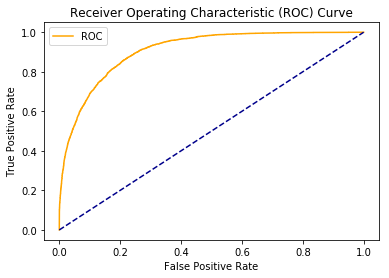

[[10470   788]
 [ 1444  2222]]
              precision    recall  f1-score   support

           0     0.8788    0.9300    0.9037     11258
           1     0.7382    0.6061    0.6657      3666

    accuracy                         0.8504     14924
   macro avg     0.8085    0.7681    0.7847     14924
weighted avg     0.8443    0.8504    0.8452     14924



In [226]:
data_train, data_test = train_test_split(minmax_stand, test_size=0.33, random_state=50)
accuracy_Score, auc_score, probs, pred = logistic_regression_no_pca(data_train,data_test,0.8)
print("Accuraccy score: %.4f" % accuracy_Score)
print("AUC: %.4f" % auc_score)
fpr, tpr, thresholds = roc_curve(data_test["Income"], probs)
plot_roc_curve(fpr, tpr)
print(confusion_matrix(data_test["Income"],pred))
print(classification_report(data_test["Income"],pred,digits=4))

#### Log Reg (PCA)

In [227]:
data_train, data_test, y_train, y_test = train_test_split(minmax_stand.drop("Income",axis=1),minmax_stand["Income"], test_size=0.33, random_state=50)
accuracy_Score, auc_score, components, probs, pred = logistic_regression_pca(data_train, data_test, y_train, y_test, 0.8)
print("Accuraccy score: %.4f" % accuracy_Score)
print("AUC: %.4f" % auc_score)
print("Broj komponenti (95% objašnjene varijance):",components)

Accuraccy score: 0.8256
AUC: 0.8777
Broj komponenti (95% objašnjene varijance): 29


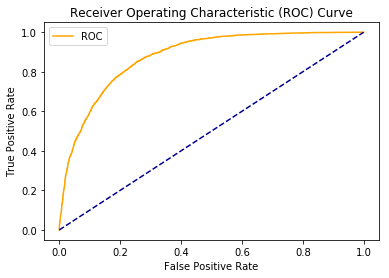

[[10252  1006]
 [ 1597  2069]]
              precision    recall  f1-score   support

           0     0.8652    0.9106    0.8874     11258
           1     0.6728    0.5644    0.6139      3666

    accuracy                         0.8256     14924
   macro avg     0.7690    0.7375    0.7506     14924
weighted avg     0.8180    0.8256    0.8202     14924



In [228]:
fpr, tpr, thresholds = roc_curve(y_test, probs)
plot_roc_curve(fpr, tpr)
print(confusion_matrix(y_test,pred))
print(classification_report(y_test,pred,digits=4))

### Random Forest

#### Random Forest (bez PCA)

In [229]:
data_train, data_test = train_test_split(minmax_stand,test_size=0.33, random_state=50)
clf=RandomForestClassifier(n_estimators=100)

clf.fit(data_train.drop("Income",axis=1),data_train["Income"])

y_pred=clf.predict(data_test.drop("Income",axis=1))

print("Accuracy:",metrics.accuracy_score(data_test["Income"], y_pred))
probs = clf.predict_proba(data_test.drop('Income',axis=1))
probs = probs[:,1]
auc_score = roc_auc_score(data_test['Income'], probs)
print("AUC: %.4f" % auc_score)

Accuracy: 0.85566872152238
AUC: 0.9054


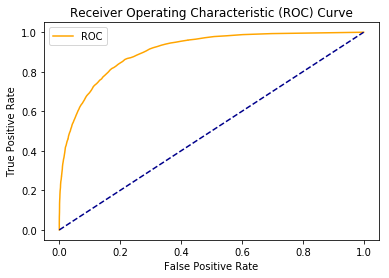

[[10448   810]
 [ 1344  2322]]
              precision    recall  f1-score   support

           0     0.8860    0.9281    0.9066     11258
           1     0.7414    0.6334    0.6831      3666

    accuracy                         0.8557     14924
   macro avg     0.8137    0.7807    0.7948     14924
weighted avg     0.8505    0.8557    0.8517     14924



In [230]:
fpr, tpr, thresholds = roc_curve(data_test['Income'], probs)
plot_roc_curve(fpr, tpr)
print(confusion_matrix(data_test['Income'],y_pred))
print(classification_report(data_test['Income'],y_pred,digits=4))

In [0]:
feature_imp = pd.Series(clf.feature_importances_,index=minmax_stand.drop("Income",axis=1).columns).sort_values(ascending=False)
importantfeat=feature_imp[0:50]
keys_imp = importantfeat.keys()
listkeys = keys_imp.tolist()
data4 = minmax_stand.drop("Income",axis=1)[listkeys]


In [232]:
X_train, X_test, y_train, y_test = train_test_split(data4, minmax_stand["Income"], test_size=0.33, random_state=50)
clf=RandomForestClassifier(n_estimators=100)

clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
probs = clf.predict_proba(X_test)
probs = probs[:,1]
auc_score = roc_auc_score(y_test, probs)
print("AUC: %.4f" % auc_score)

Accuracy: 0.8542615920664701
AUC: 0.9071


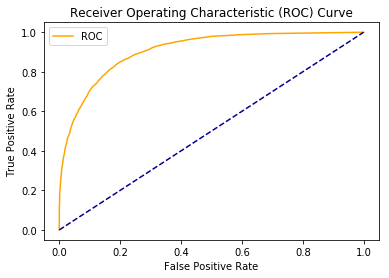

[[10432   826]
 [ 1349  2317]]
              precision    recall  f1-score   support

           0     0.8855    0.9266    0.9056     11258
           1     0.7372    0.6320    0.6806      3666

    accuracy                         0.8543     14924
   macro avg     0.8113    0.7793    0.7931     14924
weighted avg     0.8491    0.8543    0.8503     14924



In [233]:
fpr, tpr, thresholds = roc_curve(y_test, probs)
plot_roc_curve(fpr, tpr)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred,digits=4))

#### Random forest (PCA)

In [234]:
data_train, data_test, y_train, y_test = train_test_split(minmax_stand.drop("Income",axis=1),minmax_stand["Income"], test_size=0.33, random_state=50)
pca = PCA(.95)
pca.fit(data_train)

PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [0]:
data_train = pca.transform(data_train)
data_test = pca.transform(data_test)

In [236]:
pca.n_components_

29

In [237]:
clf=RandomForestClassifier(n_estimators=100)

clf.fit(data_train,y_train)

y_pred=clf.predict(data_test)


print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8213615652640043


In [238]:
probs = clf.predict_proba(data_test)
probs = probs[:,1]
auc_score = roc_auc_score(y_test, probs)
print("AUC: %.4f" % auc_score)

AUC: 0.8638


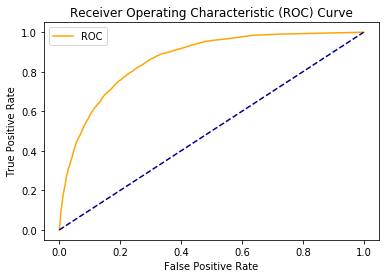

[[10133  1125]
 [ 1541  2125]]
              precision    recall  f1-score   support

           0     0.8680    0.9001    0.8837     11258
           1     0.6538    0.5797    0.6145      3666

    accuracy                         0.8214     14924
   macro avg     0.7609    0.7399    0.7491     14924
weighted avg     0.8154    0.8214    0.8176     14924



In [239]:
fpr, tpr, thresholds = roc_curve(y_test, probs)
plot_roc_curve(fpr, tpr)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred,digits=4))

### SVM

#### SVM (bez PCA)

In [240]:
data_train, data_test = train_test_split(minmax_stand,test_size=0.33, random_state=50)

clf = svm.SVC(kernel='linear',C=0.8, probability = True)
#Train the model using the training sets
clf.fit(data_train.drop("Income",axis=1), data_train["Income"])

#Predict the response for test dataset
yd_pred = clf.predict(data_test.drop("Income",axis=1))

print("Accuracy:",metrics.accuracy_score(yd_pred, data_test["Income"]))
probs = clf.predict_proba(data_test.drop('Income',axis=1))
probs = probs[:,1]
auc_score = roc_auc_score(data_test['Income'], probs)
print("AUC: %.4f" % auc_score)

Accuracy: 0.8482310372554275
AUC: 0.9043


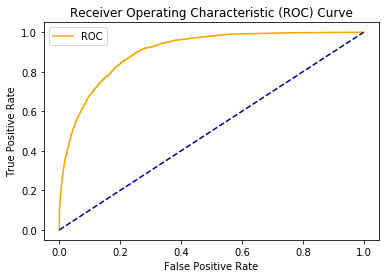

[[10133  1125]
 [ 1541  2125]]
              precision    recall  f1-score   support

           0     0.8680    0.9001    0.8837     11258
           1     0.6538    0.5797    0.6145      3666

    accuracy                         0.8214     14924
   macro avg     0.7609    0.7399    0.7491     14924
weighted avg     0.8154    0.8214    0.8176     14924



In [241]:
fpr, tpr, thresholds = roc_curve(data_test['Income'], probs)
plot_roc_curve(fpr, tpr)
print(confusion_matrix(data_test['Income'],y_pred))
print(classification_report(data_test['Income'],y_pred,digits=4))

#### SVM (PCA)

In [0]:
data_train, data_test,y_train, y_test = train_test_split(minmax_stand.drop("Income",axis=1),minmax_stand["Income"],test_size=0.33, random_state=50)
pca = PCA(.95)
pca.fit(data_train)
pca.n_components_
data_train = pca.transform(data_train)
data_test = pca.transform(data_test)

In [243]:
clf = svm.SVC(kernel='rbf',C=2.0,gamma=0.1, probability=True)
#Train the model using the training sets
clf.fit(data_train, y_train)

#Predict the response for test dataset
yd_pred = clf.predict(data_test)

print("Accuracy:",metrics.accuracy_score(yd_pred, y_test))
probs = clf.predict_proba(data_test)
probs = probs[:,1]
auc_score = roc_auc_score(y_test, probs)
print("AUC: %.4f" % auc_score)

Accuracy: 0.8251809166443312
AUC: 0.8604


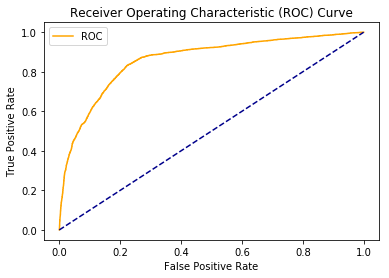

[[10133  1125]
 [ 1541  2125]]
              precision    recall  f1-score   support

           0     0.8680    0.9001    0.8837     11258
           1     0.6538    0.5797    0.6145      3666

    accuracy                         0.8214     14924
   macro avg     0.7609    0.7399    0.7491     14924
weighted avg     0.8154    0.8214    0.8176     14924



In [244]:
fpr, tpr, thresholds = roc_curve(y_test, probs)
plot_roc_curve(fpr, tpr)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred,digits=4))

### KNN algoritam

#### KNN algoritam bez PCA

In [245]:
data_train, data_test = train_test_split(minmax_stand, test_size=0.33, random_state=50)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(data_train.drop('Income',axis=1),data_train['Income'])
score_knn = knn.score(data_test.drop('Income',axis=1),data_test['Income'])
print('The accuracy of the KNN Model is',score_knn)
probs = knn.predict_proba(data_test.drop('Income',axis=1))
probs = probs[:,1]
auc_score = roc_auc_score(data_test['Income'], probs)
print("AUC: %.4f" % auc_score)

The accuracy of the KNN Model is 0.8261190029482712
AUC: 0.8505


In [246]:
knn = KNeighborsClassifier(n_neighbors=5, weights='distance', p=1)
knn.fit(data_train.drop('Income',axis=1),data_train['Income'])
score_knn = knn.score(data_test.drop('Income',axis=1),data_test['Income'])
print('The accuracy of the KNN Model is',score_knn)
probs = knn.predict_proba(data_test.drop('Income',axis=1))
probs = probs[:,1]
auc_score = roc_auc_score(data_test['Income'], probs)
print("AUC: %.4f" % auc_score)

The accuracy of the KNN Model is 0.8206915036183329
AUC: 0.8484


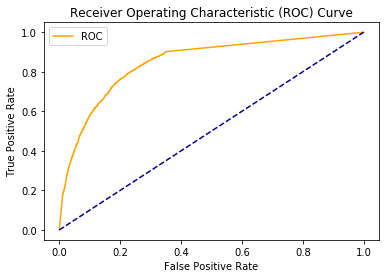

[[10133  1125]
 [ 1541  2125]]
              precision    recall  f1-score   support

           0     0.8680    0.9001    0.8837     11258
           1     0.6538    0.5797    0.6145      3666

    accuracy                         0.8214     14924
   macro avg     0.7609    0.7399    0.7491     14924
weighted avg     0.8154    0.8214    0.8176     14924



In [247]:
fpr, tpr, thresholds = roc_curve(data_test['Income'], probs)
plot_roc_curve(fpr, tpr)
print(confusion_matrix(data_test['Income'],y_pred))
print(classification_report(data_test['Income'],y_pred,digits=4))

#### KNN algoritam (PCA)

In [0]:
data_train, data_test, y_train, y_test = train_test_split(minmax_stand.drop("Income",axis=1),minmax_stand["Income"], test_size=0.33, random_state=50)
pca = PCA(.95)
pca.fit(data_train)
pca.n_components_
data_train = pca.transform(data_train)
data_test = pca.transform(data_test)

In [249]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(data_train, y_train)
score_knn = knn.score(data_test,y_test)
print('The accuracy of the KNN Model is',score_knn)
probs = knn.predict_proba(data_test)
probs = probs[:,1]
auc_score = roc_auc_score(y_test, probs)
print("AUC: %.4f" % auc_score)

The accuracy of the KNN Model is 0.8168721522380059
AUC: 0.8329


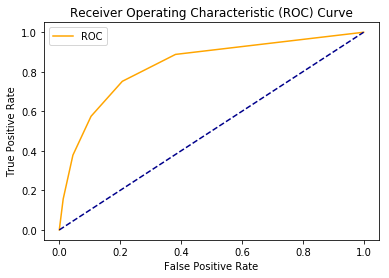

[[10133  1125]
 [ 1541  2125]]
              precision    recall  f1-score   support

           0     0.8680    0.9001    0.8837     11258
           1     0.6538    0.5797    0.6145      3666

    accuracy                         0.8214     14924
   macro avg     0.7609    0.7399    0.7491     14924
weighted avg     0.8154    0.8214    0.8176     14924



In [250]:
fpr, tpr, thresholds = roc_curve(y_test, probs)
plot_roc_curve(fpr, tpr)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred,digits=4))

In [251]:
knn = KNeighborsClassifier(n_neighbors=5, weights='distance', p=1)
knn.fit(data_train, y_train)
score_knn = knn.score(data_test,y_test)
print('The accuracy of the KNN Model is',score_knn)
probs = knn.predict_proba(data_test)
probs = probs[:,1]
auc_score = roc_auc_score(y_test, probs)
print("AUC: %.4f" % auc_score)

The accuracy of the KNN Model is 0.8087644063253819
AUC: 0.8323


### Naive Bayes

#### Naive Bayes (bez PCA)

In [252]:
data_train, data_test = train_test_split(minmax_stand, test_size=0.33, random_state=50)
gaussian_pf = GaussianNB()
gaussian_pf.partial_fit(data_train.drop('Income',axis=1),data_train['Income'], np.unique(data_train['Income']))
score_gaussian_pf = gaussian_pf.score(data_test.drop('Income',axis=1),data_test['Income'])
print('The accuracy of partial Gaussian Naive Bayes is', score_gaussian_pf)
probs = gaussian_pf.predict_proba(data_test.drop('Income',axis=1))
probs = probs[:,1]
auc_score = roc_auc_score(data_test['Income'], probs)
print("AUC: %.4f" % auc_score)

The accuracy of partial Gaussian Naive Bayes is 0.6062047708389172
AUC: 0.8568


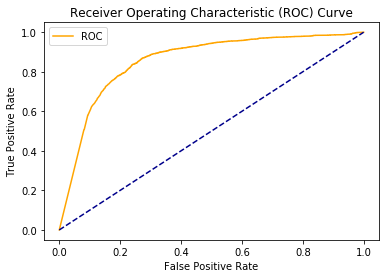

[[10133  1125]
 [ 1541  2125]]
              precision    recall  f1-score   support

           0     0.8680    0.9001    0.8837     11258
           1     0.6538    0.5797    0.6145      3666

    accuracy                         0.8214     14924
   macro avg     0.7609    0.7399    0.7491     14924
weighted avg     0.8154    0.8214    0.8176     14924



In [253]:
fpr, tpr, thresholds = roc_curve(data_test['Income'], probs)
plot_roc_curve(fpr, tpr)
print(confusion_matrix(data_test['Income'],y_pred))
print(classification_report(data_test['Income'],y_pred,digits=4))

In [254]:
gaussian = GaussianNB()
gaussian.fit(data_train.drop('Income',axis=1),data_train['Income'])
score_gaussian = gaussian.score(data_test.drop('Income',axis=1),data_test['Income'])
print('The accuracy of Gaussian Naive Bayes is', score_gaussian)
probs = gaussian.predict_proba(data_test.drop('Income',axis=1))
probs = probs[:,1]
auc_score = roc_auc_score(data_test['Income'], probs)
print("AUC: %.4f" % auc_score)

The accuracy of Gaussian Naive Bayes is 0.6062047708389172
AUC: 0.8568


#### Naive-Bayes (PCA)

In [0]:
data_train, data_test, y_train, y_test = train_test_split(minmax_stand.drop("Income",axis=1),minmax_stand["Income"], test_size=0.33, random_state=50)
pca = PCA(.95)
pca.fit(data_train)
pca.n_components_
data_train = pca.transform(data_train)
data_test = pca.transform(data_test)

In [256]:
gaussian_pf = GaussianNB()
gaussian_pf.partial_fit(data_train, y_train, np.unique(y_train))
score_gaussian_pf = gaussian_pf.score(data_test,y_test)
print('The accuracy of partial Gaussian Naive Bayes is', score_gaussian_pf)
probs = gaussian_pf.predict_proba(data_test)
probs = probs[:,1]
auc_score = roc_auc_score(y_test, probs)
print("AUC: %.4f" % auc_score)

The accuracy of partial Gaussian Naive Bayes is 0.7436344143661217
AUC: 0.8170


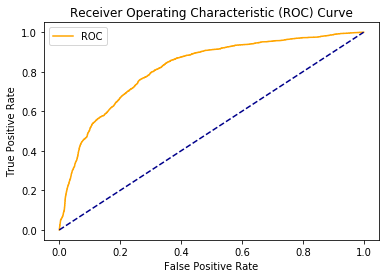

[[10133  1125]
 [ 1541  2125]]
              precision    recall  f1-score   support

           0     0.8680    0.9001    0.8837     11258
           1     0.6538    0.5797    0.6145      3666

    accuracy                         0.8214     14924
   macro avg     0.7609    0.7399    0.7491     14924
weighted avg     0.8154    0.8214    0.8176     14924



In [257]:
fpr, tpr, thresholds = roc_curve(y_test, probs)
plot_roc_curve(fpr, tpr)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred,digits=4))

In [258]:
gaussian = GaussianNB()
gaussian.fit(data_train,y_train)
score_gaussian = gaussian.score(data_test,y_test)
print('The accuracy of Gaussian Naive Bayes is', score_gaussian)
probs = gaussian.predict_proba(data_test)
probs = probs[:,1]
auc_score = roc_auc_score(y_test, probs)
print("AUC: %.4f" % auc_score)

The accuracy of Gaussian Naive Bayes is 0.7436344143661217
AUC: 0.8170


### Neuronske mreze

In [0]:
X_train, X_test,y_train, y_test = train_test_split(minmax_stand.drop("Income",axis=1),minmax_stand["Income"], test_size=0.33, random_state=50)

In [260]:
from sklearn.neural_network import MLPClassifier  
mlp = MLPClassifier(hidden_layer_sizes=(10, 10, 10), max_iter=1000, random_state=1)  
mlp.fit(X_train, y_train.values.ravel()) 
predictions = mlp.predict(X_test)
from sklearn.metrics import classification_report, confusion_matrix  
print(confusion_matrix(y_test,predictions))  
print(classification_report(y_test,predictions,digits=4))
probs = mlp.predict_proba(X_test)
probs = probs[:,1]
auc_score = roc_auc_score(y_test, probs)
print("AUC: %.4f" % auc_score)

[[10360   898]
 [ 1317  2349]]
              precision    recall  f1-score   support

           0     0.8872    0.9202    0.9034     11258
           1     0.7234    0.6408    0.6796      3666

    accuracy                         0.8516     14924
   macro avg     0.8053    0.7805    0.7915     14924
weighted avg     0.8470    0.8516    0.8484     14924

AUC: 0.9102


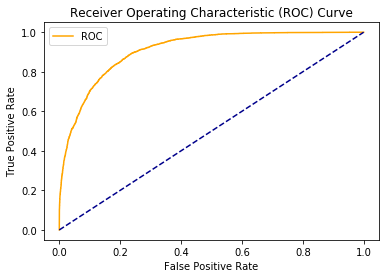

In [261]:
fpr, tpr, thresholds = roc_curve(y_test, probs)
plot_roc_curve(fpr, tpr)

In [262]:
from sklearn.neural_network import MLPClassifier  
mlp = MLPClassifier(hidden_layer_sizes=(13, 13, 13, 13), max_iter=1000, random_state=1)  
mlp.fit(X_train, y_train.values.ravel())
predictions = mlp.predict(X_test)
from sklearn.metrics import classification_report, confusion_matrix  
print(confusion_matrix(y_test,predictions))  
print(classification_report(y_test,predictions,digits=4))
probs = mlp.predict_proba(X_test)
probs = probs[:,1]
auc_score = roc_auc_score(y_test, probs)
print("AUC: %.4f" % auc_score)

[[10356   902]
 [ 1352  2314]]
              precision    recall  f1-score   support

           0     0.8845    0.9199    0.9019     11258
           1     0.7195    0.6312    0.6725      3666

    accuracy                         0.8490     14924
   macro avg     0.8020    0.7755    0.7872     14924
weighted avg     0.8440    0.8490    0.8455     14924

AUC: 0.9051


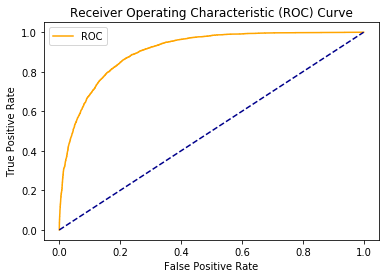

In [263]:
fpr, tpr, thresholds = roc_curve(y_test, probs)
plot_roc_curve(fpr, tpr)

In [264]:
from sklearn.neural_network import MLPClassifier  
mlp = MLPClassifier(hidden_layer_sizes=(13, 13, 13), max_iter=500, random_state=1, solver='sgd')  
mlp.fit(X_train, y_train.values.ravel()) 
predictions = mlp.predict(X_test)
from sklearn.metrics import classification_report, confusion_matrix  
print(confusion_matrix(y_test,predictions))  
print(classification_report(y_test,predictions,digits=4))
probs = mlp.predict_proba(X_test)
probs = probs[:,1]
auc_score = roc_auc_score(y_test, probs)
print("AUC: %.4f" % auc_score)

[[10334   924]
 [ 1283  2383]]
              precision    recall  f1-score   support

           0     0.8896    0.9179    0.9035     11258
           1     0.7206    0.6500    0.6835      3666

    accuracy                         0.8521     14924
   macro avg     0.8051    0.7840    0.7935     14924
weighted avg     0.8481    0.8521    0.8495     14924

AUC: 0.9096


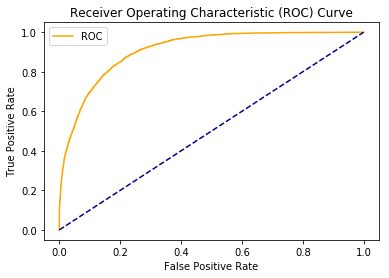

In [265]:
fpr, tpr, thresholds = roc_curve(y_test, probs)
plot_roc_curve(fpr, tpr)

## Promjene u datasetu

U ovom odjeljku pokušali smo s micanjem nekih svojstava ili promjenom vrsta svojstva (kategorijska u numerička ili obratno). Za sve promjene koristili smo StandardScaler.

Dobiveni rezultati se nisu pretjerano razlikovali od dosad utvrđenih. Nismo dobili poboljšanja, a nakon nekih od preuređivanja dobili smo lošije rezultate. Zato ćemo ovaj dio ukratko prikazati.

Osim prikazanih promjena u podacima (diskretizacija svih svojstva i micanje određenih svojstava) pokušali smo s još nekim promjenama poput micanja različitih vrsta svojstava koji su se činili da možda nisu nezavisni, no ni u jednom slučaju nismo dobili bolje rezultate od dosadašnjih pa smo dolučili taj dio izbaciti.

### StandardScaler normalizacija

Numerička svojstva normaliziramo sa StandardScaler ugrađenom funkcijom u sklearn-u. Kategorijska svojstva koje nisu ordinalne (sve osim education-num) prevaramo u dummy-varijable pomoću OneHot encoding-a. Za Education-num provodimo isti postupak kao i za numerička svojstva.

In [0]:
from sklearn.preprocessing import StandardScaler

Pogledajmo razdiobu svojstva Age prije i nakon normalizacije.

In [0]:
data_noNaN["Age"].describe()

count    45222.000000
mean        38.547941
std         13.217870
min         17.000000
25%         28.000000
50%         37.000000
75%         47.000000
max         90.000000
Name: Age, dtype: float64

In [0]:
stand_age = StandardScaler().fit_transform(data_noNaN[["Age","fnlwgt","Capital-gain","Capital-loss","Hours-per-week","Education-num"]])
norm_stand_age = stand_age[:,0]
norm_stand_fnlwgt = stand_age[:,1]
norm_stand_gain = stand_age[:,2]
norm_stand_loss = stand_age[:,3]
norm_stand_hours = stand_age[:,4]
norm_stand_edu = stand_age[:,5]

In [0]:
pd_norm_age=pd.DataFrame(norm_stand_age).describe()
pd_norm_age

,0
count,4.522200e+04
mean,-7.767780e-17
std,1.000011e+00
min,-1.630231e+00
25%,-7.980149e-01
50%,-1.171110e-01
75%,6.394489e-01
max,3.892656e+00


Uočimo kako je StandardScaler transformirao podatke tako da je njihova aritmetička sredina jednaka 0, a standardna devijacija jedinici.

In [0]:
data_rem_stand = data_noNaN[['Workclass','Race','Marital-status','Occupation','Relationship','Native-country','Sex','Education-num']]

In [0]:
data_rem_stand["Age"] = norm_stand_age
data_rem_stand["fnlwgt"] = norm_stand_fnlwgt
data_rem_stand["Capital-gain"] = norm_stand_gain
data_rem_stand["Capital-loss"] = norm_stand_loss
data_rem_stand["Hours-per-week"] = norm_stand_hours
data_rem_stand["Education-num"] = norm_stand_edu
data_rem_stand.head(5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/p

,Workclass,Race,Marital-status,Occupation,Relationship,Native-country,Sex,Education-num,Age,fnlwgt,Capital-gain,Capital-loss,Hours-per-week
0,0,0,0,0,0,0,0,-1.221559,-1.024983,0.350889,-0.146733,-0.21878,-0.078120
1,0,1,1,1,1,0,0,-0.438122,-0.041455,-0.945878,-0.146733,-0.21878,0.754701
2,1,1,1,2,1,0,0,0.737034,-0.798015,1.393592,-0.146733,-0.21878,-0.078120
3,0,0,1,0,1,0,0,-0.046403,0.412481,-0.278420,0.877467,-0.21878,-0.078120
4,0,1,0,3,2,0,0,-1.613277,-0.344079,0.084802,-0.146733,-0.21878,-0.910942


Mičemo svojstvo 'Relationship' jer ima zančajnu korelaciju sa svojstvom 'Marital-status'. Također 90% instanci ima vrijednost svojstva  'Native-country' USA. Pokušajmo i s micanjem spola.

In [0]:
data_rem_stand=data_rem_stand.drop('Relationship',axis=1)
data_rem_stand=data_rem_stand.drop("Native-country",axis=1)
data_rem_stand=data_rem_stand.drop("Sex",axis=1)

In [0]:
from sklearn.preprocessing import OneHotEncoder
data_noNaN2 = data_rem_stand[['Workclass','Race','Marital-status','Occupation']]
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
data_ohe_noNaN = ohe.fit_transform(data_noNaN2)
data_rem_stand = data_rem_stand[["Age","fnlwgt","Capital-gain","Capital-loss","Hours-per-week","Education-num"]]

In [0]:
for i in range(0,np.size(data_ohe_noNaN,1)):
    columni="column"+str(i)
    data_rem_stand[columni] = data_ohe_noNaN[:,i]
    
data_rem_stand["Income"] = data_noNaN["Income"]
data_rem_stand.head(10)

,Age,fnlwgt,Capital-gain,Capital-loss,Hours-per-week,Education-num,column0,column1,column2,column3,column4,column5,column6,column7,column8,column9,column10,column11,column12,column13,column14,column15,column16,column17,column18,column19,column20,column21,column22,column23,column24,column25,column26,column27,column28,column29,column30,column31,column32,Income
0,-1.024983,0.350889,-0.146733,-0.21878,-0.078120,-1.221559,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,-0.041455,-0.945878,-0.146733,-0.21878,0.754701,-0.438122,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,-0.798015,1.393592,-0.146733,-0.21878,-0.078120,0.737034,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.412481,-0.278420,0.877467,-0.21878,-0.078120,-0.046403,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,-0.344079,0.084802,-0.146733,-0.21878,-0.910942,-1.613277,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
5,1.849945,-0.805664,0.266650,-0.21878,-0.744377,1.912190,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
6,-1.100639,1.703291,-0.146733,-0.21878,-0.078120,-0.046403,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
7,1.244697,-0.802161,-0.146733,-0.21878,-2.576584,-2.396715,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
8,2.001257,-0.049989,0.708277,-0.21878,-0.078120,-0.438122,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
9,-0.192767,0.215171,-0.146733,-0.21878,-0.078120,1.128753,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


### DIskretizacija normalnih vrijednosti

In [0]:
from sklearn.preprocessing import KBinsDiscretizer

In [0]:
standb_age = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile').fit_transform(data_noNaN[["Age","fnlwgt","Capital-gain","Capital-loss","Hours-per-week"]])
norm_standb_age = standb_age[:,0]
norm_standb_fnlwgt = standb_age[:,1]
norm_standb_gain = standb_age[:,2]
norm_standb_loss = standb_age[:,3]
norm_standb_hours = standb_age[:,4]

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:193: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:193: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 3 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:193: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 4 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)


In [0]:
data_remKB_stand = data_noNaN[['Workclass','Race','Marital-status','Occupation','Relationship','Native-country','Sex','Education-num']]

In [0]:
data_remKB_stand["Age"] = norm_standb_age
data_remKB_stand["fnlwgt"] = norm_standb_fnlwgt
data_remKB_stand["Capital-gain"] = norm_standb_gain
data_remKB_stand["Capital-loss"] = norm_standb_loss
data_remKB_stand["Hours-per-week"] = norm_standb_hours
#data_rem_stand["Education-num"] = norm_stand_edu
data_remKB_stand.head(5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/p

,Workclass,Race,Marital-status,Occupation,Relationship,Native-country,Sex,Education-num,Age,fnlwgt,Capital-gain,Capital-loss,Hours-per-week
0,0,0,0,0,0,0,0,7,0.0,3.0,0.0,0.0,2.0
1,0,1,1,1,1,0,0,9,2.0,0.0,0.0,0.0,3.0
2,1,1,1,2,1,0,0,12,1.0,4.0,0.0,0.0,2.0
3,0,0,1,0,1,0,0,10,3.0,2.0,0.0,0.0,2.0
4,0,1,0,3,2,0,0,6,2.0,3.0,0.0,0.0,0.0


In [0]:
#data_rem_stand = data_rem_stand[["Age","fnlwgt","Capital-gain","Capital-loss","Hours-per-week","Education-num"]]
from sklearn.preprocessing import OneHotEncoder
data_noNaN2 = data_remKB_stand[['Workclass','Race','Marital-status','Occupation',"Age","fnlwgt","Capital-gain","Capital-loss","Hours-per-week","Education-num",'Relationship','Native-country','Sex']]
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
data_ohe_noNaN = ohe.fit_transform(data_noNaN2)


In [0]:
np.size(data_ohe_noNaN,1)

114

In [0]:
data_rem2_stand=pd.DataFrame()

In [0]:
for i in range(0,114):
    columni="column"+str(i)
    data_rem2_stand[columni] = data_ohe_noNaN[:,i]
    
data_rem2_stand["Income"] = data_noNaN["Income"]
data_rem2_stand.head(10)

,column0,column1,column2,column3,column4,column5,column6,column7,column8,column9,column10,column11,column12,column13,column14,column15,column16,column17,column18,column19,column20,column21,column22,column23,column24,column25,column26,column27,column28,column29,column30,column31,column32,column33,column34,column35,column36,column37,column38,column39,...,column75,column76,column77,column78,column79,column80,column81,column82,column83,column84,column85,column86,column87,column88,column89,column90,column91,column92,column93,column94,column95,column96,column97,column98,column99,column100,column101,column102,column103,column104,column105,column106,column107,column108,column109,column110,column111,column112,column113,Income
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
7,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
9,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0


Ostali načini i kombinacije micanja nekih svojstava i raznih kombinacija nisu doveli do poboljšanja pa smo odlučili ne prikazati ih. Skupovi podataka sa maknutim određenim svojstvima je data_rem_stand, dok onaj u kojem su sva svojstva diskretizirana data_rem2_stand.

### Log Reg

#### Log Reg (bez PCA)

In [0]:
data_train, data_test, y_train, y_test = train_test_split(data_rem_stand.drop("Income",axis=1),data_rem_stand["Income"], test_size=0.33, random_state=50)
model = Pipeline([('logistic', LogisticRegression(penalty='l1',C=0.8, solver='liblinear'))]) 
model.fit(data_train,y_train)
accuracy_test = model.score(data_test,y_test) 
# Tocnost je default mjera za LogisticRegression()

print("Accuracy: ", accuracy_test)
probs = model.predict_proba(data_test)
probs = probs[:,1]
auc_score = roc_auc_score(y_test, probs)
print("AUC: %.4f" % auc_score)

Accuracy:  0.8485660680782632
AUC: 0.9050


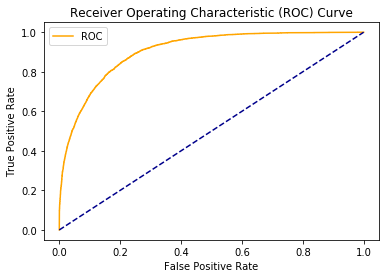

[[10123  1135]
 [ 1553  2113]]
              precision    recall  f1-score   support

           0     0.8670    0.8992    0.8828     11258
           1     0.6506    0.5764    0.6112      3666

    accuracy                         0.8199     14924
   macro avg     0.7588    0.7378    0.7470     14924
weighted avg     0.8138    0.8199    0.8161     14924



In [0]:
fpr, tpr, thresholds = roc_curve(y_test, probs)
plot_roc_curve(fpr, tpr)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred,digits=4))

In [0]:
data_train, data_test, y_train, y_test = train_test_split(data_rem2_stand.drop("Income",axis=1),data_rem_stand["Income"], test_size=0.33, random_state=50)
model = Pipeline([('logistic', LogisticRegression(penalty='l1',C=0.8, solver='liblinear'))]) 
model.fit(data_train,y_train)
accuracy_test = model.score(data_test,y_test) 
# Tocnost je default mjera za LogisticRegression()

print("Accuracy: ", accuracy_test)
probs = model.predict_proba(data_test)
probs = probs[:,1]
auc_score = roc_auc_score(y_test, probs)
print("AUC: %.4f" % auc_score)

Accuracy:  0.8371080139372822
AUC: 0.8928


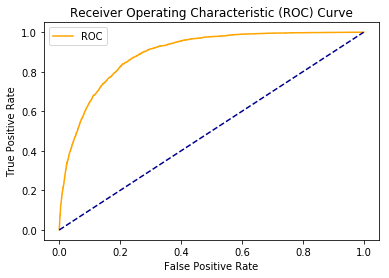

[[10123  1135]
 [ 1553  2113]]
              precision    recall  f1-score   support

           0     0.8670    0.8992    0.8828     11258
           1     0.6506    0.5764    0.6112      3666

    accuracy                         0.8199     14924
   macro avg     0.7588    0.7378    0.7470     14924
weighted avg     0.8138    0.8199    0.8161     14924



In [0]:
fpr, tpr, thresholds = roc_curve(y_test, probs)
plot_roc_curve(fpr, tpr)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred,digits=4))

#### Log Reg (PCA)

In [0]:
from sklearn.decomposition import PCA
data_train, data_test, y_train, y_test = train_test_split(data_rem_stand.drop("Income",axis=1),data_rem_stand["Income"], test_size=0.33, random_state=50)
pca = PCA(.95)
pca.fit(data_train)
pca.n_components_
data_train = pca.transform(data_train)
data_test = pca.transform(data_test)

In [0]:
model = Pipeline([('logistic', LogisticRegression(penalty='l1',C=0.8, solver='liblinear'))]) 
model.fit(data_train,y_train)
accuracy_test = model.score(data_test,y_test)

print("Accuracy: ", accuracy_test)
probs = model.predict_proba(data_test)
probs = probs[:,1]
auc_score = roc_auc_score(y_test, probs)
print("AUC: %.4f" % auc_score)

Accuracy:  0.8464218708121147
AUC: 0.9015


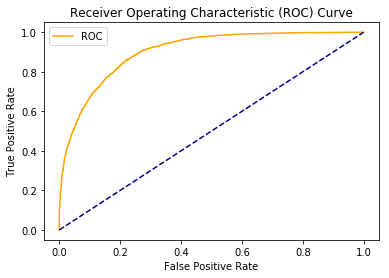

[[10123  1135]
 [ 1553  2113]]
              precision    recall  f1-score   support

           0     0.8670    0.8992    0.8828     11258
           1     0.6506    0.5764    0.6112      3666

    accuracy                         0.8199     14924
   macro avg     0.7588    0.7378    0.7470     14924
weighted avg     0.8138    0.8199    0.8161     14924



In [0]:
fpr, tpr, thresholds = roc_curve(y_test, probs)
plot_roc_curve(fpr, tpr)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred,digits=4))

In [0]:
from sklearn.decomposition import PCA
data_train, data_test, y_train, y_test = train_test_split(data_rem2_stand.drop("Income",axis=1),data_rem2_stand["Income"], test_size=0.33, random_state=50)
pca = PCA(.95)
pca.fit(data_train)
pca.n_components_
data_train = pca.transform(data_train)
data_test = pca.transform(data_test)

In [0]:
model = Pipeline([('logistic', LogisticRegression(penalty='l1',C=0.8, solver='liblinear'))]) 
model.fit(data_train,y_train)
accuracy_test = model.score(data_test,y_test)

print("Accuracy: ", accuracy_test)
probs = model.predict_proba(data_test)
probs = probs[:,1]
auc_score = roc_auc_score(y_test, probs)
print("AUC: %.4f" % auc_score)

Accuracy:  0.8339587242026266
AUC: 0.8861


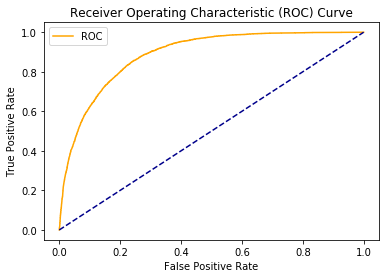

[[10123  1135]
 [ 1553  2113]]
              precision    recall  f1-score   support

           0     0.8670    0.8992    0.8828     11258
           1     0.6506    0.5764    0.6112      3666

    accuracy                         0.8199     14924
   macro avg     0.7588    0.7378    0.7470     14924
weighted avg     0.8138    0.8199    0.8161     14924



In [0]:
fpr, tpr, thresholds = roc_curve(y_test, probs)
plot_roc_curve(fpr, tpr)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred,digits=4))

### Random Forest

#### Random Forest (bez PCA)

In [0]:
data_train, data_test = train_test_split(data_rem_stand,test_size=0.33, random_state=50)
clf=RandomForestClassifier(n_estimators=100)

clf.fit(data_train.drop("Income",axis=1),data_train["Income"])

y_pred=clf.predict(data_test.drop("Income",axis=1))

print("Accuracy:",metrics.accuracy_score(data_test["Income"], y_pred))
probs = clf.predict_proba(data_test.drop('Income',axis=1))
probs = probs[:,1]
auc_score = roc_auc_score(data_test['Income'], probs)
print("AUC: %.4f" % auc_score)

Accuracy: 0.8536585365853658
AUC: 0.9055


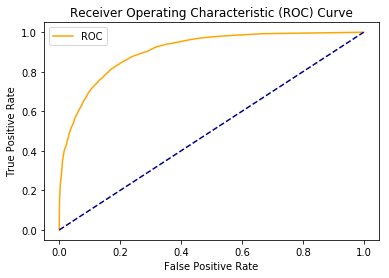

[[10428   830]
 [ 1354  2312]]
              precision    recall  f1-score   support

           0     0.8851    0.9263    0.9052     11258
           1     0.7358    0.6307    0.6792      3666

    accuracy                         0.8537     14924
   macro avg     0.8105    0.7785    0.7922     14924
weighted avg     0.8484    0.8537    0.8497     14924



In [0]:
fpr, tpr, thresholds = roc_curve(y_test, probs)
plot_roc_curve(fpr, tpr)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred,digits=4))

In [0]:
feature_imp = pd.Series(clf.feature_importances_,index=data_rem_stand.drop("Income",axis=1).columns).sort_values(ascending=False)
importantfeat=feature_imp[0:50]
keys_imp = importantfeat.keys()
listkeys = keys_imp.tolist()
data4 = data_rem_stand.drop("Income",axis=1)[listkeys]


In [0]:
X_train, X_test, y_train, y_test = train_test_split(data4, data_rem_stand["Income"], test_size=0.33, random_state=50)
clf=RandomForestClassifier(n_estimators=100)

clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
probs = clf.predict_proba(X_test)
probs = probs[:,1]
auc_score = roc_auc_score(y_test, probs)
print("AUC: %.4f" % auc_score)

Accuracy: 0.8549986598767086
AUC: 0.9051


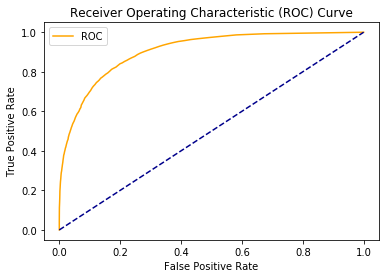

[[10442   816]
 [ 1348  2318]]
              precision    recall  f1-score   support

           0     0.8857    0.9275    0.9061     11258
           1     0.7396    0.6323    0.6818      3666

    accuracy                         0.8550     14924
   macro avg     0.8126    0.7799    0.7939     14924
weighted avg     0.8498    0.8550    0.8510     14924



In [0]:
fpr, tpr, thresholds = roc_curve(y_test, probs)
plot_roc_curve(fpr, tpr)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred,digits=4))

In [0]:
data_train, data_test = train_test_split(data_rem2_stand,test_size=0.33, random_state=50)
clf=RandomForestClassifier(n_estimators=100)

clf.fit(data_train.drop("Income",axis=1),data_train["Income"])

y_pred=clf.predict(data_test.drop("Income",axis=1))

print("Accuracy:",metrics.accuracy_score(data_test["Income"], y_pred))
probs = clf.predict_proba(data_test.drop('Income',axis=1))
probs = probs[:,1]
auc_score = roc_auc_score(data_test['Income'], probs)
print("AUC: %.4f" % auc_score)

Accuracy: 0.8182122755293487
AUC: 0.8608


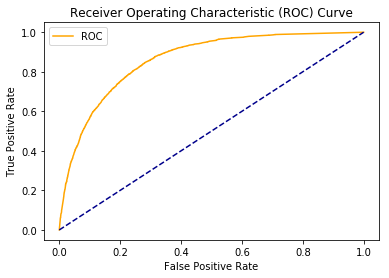

[[10126  1132]
 [ 1581  2085]]
              precision    recall  f1-score   support

           0     0.8650    0.8994    0.8819     11258
           1     0.6481    0.5687    0.6058      3666

    accuracy                         0.8182     14924
   macro avg     0.7565    0.7341    0.7439     14924
weighted avg     0.8117    0.8182    0.8141     14924



In [0]:
fpr, tpr, thresholds = roc_curve(data_test['Income'], probs)
plot_roc_curve(fpr, tpr)
print(confusion_matrix(data_test['Income'],y_pred))
print(classification_report(data_test['Income'],y_pred,digits=4))

In [0]:
feature_imp = pd.Series(clf.feature_importances_,index=data_rem2_stand.drop("Income",axis=1).columns).sort_values(ascending=False)
importantfeat=feature_imp[0:50]
keys_imp = importantfeat.keys()
listkeys = keys_imp.tolist()
data4 = data_rem2_stand.drop("Income",axis=1)[listkeys]


In [0]:
X_train, X_test, y_train, y_test = train_test_split(data4, data_rem2_stand["Income"], test_size=0.33, random_state=50)
clf=RandomForestClassifier(n_estimators=100)

clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
probs = clf.predict_proba(X_test)
probs = probs[:,1]
auc_score = roc_auc_score(y_test, probs)
print("AUC: %.4f" % auc_score)

Accuracy: 0.8158670597694988
AUC: 0.8586


#### Random forest (PCA)

In [0]:
data_train, data_test, y_train, y_test = train_test_split(data_rem_stand.drop("Income",axis=1),data_rem_stand["Income"], test_size=0.33, random_state=50)
pca = PCA(.95)
pca.fit(data_train)
data_train = pca.transform(data_train)
data_test = pca.transform(data_test)
pca.n_components_

18

In [0]:
clf=RandomForestClassifier(n_estimators=100)

clf.fit(data_train,y_train)

y_pred=clf.predict(data_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
probs = clf.predict_proba(data_test)
probs = probs[:,1]
auc_score = roc_auc_score(y_test, probs)
print("AUC: %.4f" % auc_score)
print(confusion_matrix(y_test,y_test))

Accuracy: 0.8421334762798177
AUC: 0.8957
[[11258     0]
 [    0  3666]]


In [0]:
data_train, data_test, y_train, y_test = train_test_split(data_rem2_stand.drop("Income",axis=1),data_rem2_stand["Income"], test_size=0.33, random_state=50)
pca = PCA(.95)
pca.fit(data_train)
data_train = pca.transform(data_train)
data_test = pca.transform(data_test)
pca.n_components_

42

In [0]:
clf=RandomForestClassifier(n_estimators=100)

clf.fit(data_train,y_train)

y_pred=clf.predict(data_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
probs = clf.predict_proba(data_test)
probs = probs[:,1]
auc_score = roc_auc_score(y_test, probs)
print("AUC: %.4f" % auc_score)

Accuracy: 0.8184132940230501
AUC: 0.8567


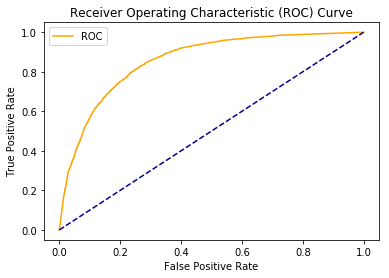

[[10230  1028]
 [ 1682  1984]]
              precision    recall  f1-score   support

           0     0.8588    0.9087    0.8830     11258
           1     0.6587    0.5412    0.5942      3666

    accuracy                         0.8184     14924
   macro avg     0.7587    0.7249    0.7386     14924
weighted avg     0.8096    0.8184    0.8121     14924



In [0]:
fpr, tpr, thresholds = roc_curve(y_test, probs)
plot_roc_curve(fpr, tpr)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred,digits=4))

### SVM

#### SVM (bez PCA)

In [0]:
data_train, data_test = train_test_split(data_rem_stand,test_size=0.33, random_state=50)

clf = svm.SVC(kernel='linear',C=0.8,probability=True)
#Train the model using the training sets
clf.fit(data_train.drop("Income",axis=1), data_train["Income"])

#Predict the response for test dataset
yd_pred = clf.predict(data_test.drop("Income",axis=1))

print("Accuracy:",metrics.accuracy_score(yd_pred, data_test["Income"]))
probs = clf.predict_proba(data_test.drop('Income',axis=1))
probs = probs[:,1]
auc_score = roc_auc_score(data_test['Income'], probs)
print("AUC: %.4f" % auc_score)

Accuracy: 0.8491691235593675
AUC: 0.9029


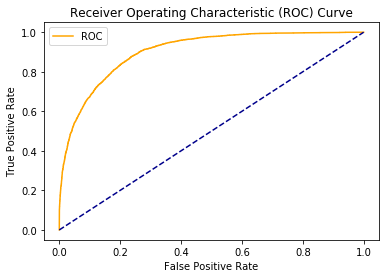

[[10230  1028]
 [ 1682  1984]]
              precision    recall  f1-score   support

           0     0.8588    0.9087    0.8830     11258
           1     0.6587    0.5412    0.5942      3666

    accuracy                         0.8184     14924
   macro avg     0.7587    0.7249    0.7386     14924
weighted avg     0.8096    0.8184    0.8121     14924



In [0]:
fpr, tpr, thresholds = roc_curve(data_test['Income'], probs)
plot_roc_curve(fpr, tpr)
print(confusion_matrix(data_test['Income'],y_pred))
print(classification_report(data_test['Income'],y_pred,digits=4))

#### SVM (PCA)

In [0]:
data_train, data_test,y_train, y_test = train_test_split(data_rem_stand.drop("Income",axis=1),data_rem_stand["Income"],test_size=0.33, random_state=50)
pca = PCA(.95)
pca.fit(data_train)
pca.n_components_
data_train = pca.transform(data_train)
data_test = pca.transform(data_test)

In [0]:
clf = svm.SVC(kernel='rbf',C=2.0,gamma=0.1,probability=True)
#Train the model using the training sets
clf.fit(data_train, y_train)

#Predict the response for test dataset
yd_pred = clf.predict(data_test)

print("Accuracy:",metrics.accuracy_score(yd_pred, y_test))
probs = clf.predict_proba(data_test)
probs = probs[:,1]
auc_score = roc_auc_score(y_test, probs)
print("AUC: %.4f" % auc_score)

Accuracy: 0.8530554811042615
AUC: 0.8839


In [0]:
fpr, tpr, thresholds = roc_curve(y_test, probs)
plot_roc_curve(fpr, tpr)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred,digits=4))

### KNN algoritam

#### KNN algoritam bez PCA

In [0]:
data_train, data_test = train_test_split(data_rem_stand, test_size=0.33, random_state=50)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(data_train.drop('Income',axis=1),data_train['Income'])
score_knn = knn.score(data_test.drop('Income',axis=1),data_test['Income'])
print('The accuracy of the KNN Model is',score_knn)
probs = knn.predict_proba(data_test.drop('Income',axis=1))
probs = probs[:,1]
auc_score = roc_auc_score(data_test['Income'], probs)
print("AUC: %.4f" % auc_score)

The accuracy of the KNN Model is 0.8338247118734924
AUC: 0.8647


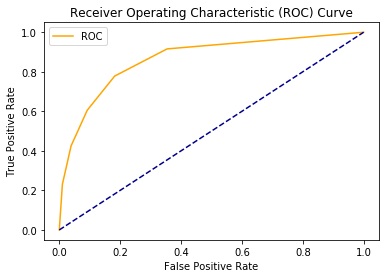

[[10230  1028]
 [ 1682  1984]]
              precision    recall  f1-score   support

           0     0.8588    0.9087    0.8830     11258
           1     0.6587    0.5412    0.5942      3666

    accuracy                         0.8184     14924
   macro avg     0.7587    0.7249    0.7386     14924
weighted avg     0.8096    0.8184    0.8121     14924



In [0]:
fpr, tpr, thresholds = roc_curve(data_test['Income'], probs)
plot_roc_curve(fpr, tpr)
print(confusion_matrix(data_test['Income'],y_pred))
print(classification_report(data_test['Income'],y_pred,digits=4))

In [0]:
knn = KNeighborsClassifier(n_neighbors=5, weights='distance', p=1)
knn.fit(data_train.drop('Income',axis=1),data_train['Income'])
score_knn = knn.score(data_test.drop('Income',axis=1),data_test['Income'])
print('The accuracy of the KNN Model is',score_knn)
probs = knn.predict_proba(data_test.drop('Income',axis=1))
probs = probs[:,1]
auc_score = roc_auc_score(data_test['Income'], probs)
print("AUC: %.4f" % auc_score)

The accuracy of the KNN Model is 0.8313454837845081
AUC: 0.8633


#### KNN algoritam (PCA)

In [0]:
data_train, data_test, y_train, y_test = train_test_split(data_rem_stand.drop("Income",axis=1),data_rem_stand["Income"], test_size=0.33, random_state=50)
pca = PCA(.95)
pca.fit(data_train)
pca.n_components_
data_train = pca.transform(data_train)
data_test = pca.transform(data_test)

In [0]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(data_train, y_train)
score_knn = knn.score(data_test,y_test)
print('The accuracy of the KNN Model is',score_knn)
probs = knn.predict_proba(data_test)
probs = probs[:,1]
auc_score = roc_auc_score(y_test, probs)
print("AUC: %.4f" % auc_score)

The accuracy of the KNN Model is 0.8329536317341195
AUC: 0.8624


In [0]:
knn = KNeighborsClassifier(n_neighbors=5, weights='distance', p=1)
knn.fit(data_train, y_train)
score_knn = knn.score(data_test,y_test)
print('The accuracy of the KNN Model is',score_knn)
probs = knn.predict_proba(data_test)
probs = probs[:,1]
auc_score = roc_auc_score(y_test, probs)
print("AUC: %.4f" % auc_score)

The accuracy of the KNN Model is 0.8292682926829268
AUC: 0.8621


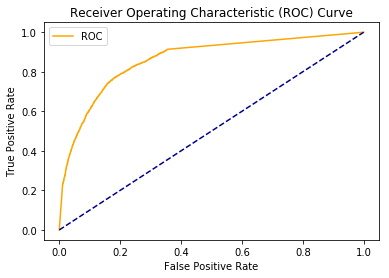

[[10230  1028]
 [ 1682  1984]]
              precision    recall  f1-score   support

           0     0.8588    0.9087    0.8830     11258
           1     0.6587    0.5412    0.5942      3666

    accuracy                         0.8184     14924
   macro avg     0.7587    0.7249    0.7386     14924
weighted avg     0.8096    0.8184    0.8121     14924



In [0]:
fpr, tpr, thresholds = roc_curve(y_test, probs)
plot_roc_curve(fpr, tpr)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred,digits=4))

### Naive Bayes

#### Naive Bayes (bez PCA)

In [0]:
data_train, data_test = train_test_split(data_rem_stand, test_size=0.33, random_state=50)
gaussian_pf = GaussianNB()
gaussian_pf.partial_fit(data_train.drop('Income',axis=1),data_train['Income'], np.unique(data_train['Income']))
score_gaussian_pf = gaussian_pf.score(data_test.drop('Income',axis=1),data_test['Income'])
print('The accuracy of partial Gaussian Naive Bayes is', score_gaussian_pf)
probs = gaussian_pf.predict_proba(data_test.drop('Income',axis=1))
probs = probs[:,1]
auc_score = roc_auc_score(data_test['Income'], probs)
print("AUC: %.4f" % auc_score)

The accuracy of partial Gaussian Naive Bayes is 0.7707049048512463
AUC: 0.8617


In [0]:
data_train, data_test = train_test_split(data_rem2_stand, test_size=0.33, random_state=50)
gaussian_pf = GaussianNB()
gaussian_pf.partial_fit(data_train.drop('Income',axis=1),data_train['Income'], np.unique(data_train['Income']))
score_gaussian_pf = gaussian_pf.score(data_test.drop('Income',axis=1),data_test['Income'])
print('The accuracy of partial Gaussian Naive Bayes is', score_gaussian_pf)
probs = gaussian_pf.predict_proba(data_test.drop('Income',axis=1))
probs = probs[:,1]
auc_score = roc_auc_score(data_test['Income'], probs)
print("AUC: %.4f" % auc_score)

The accuracy of partial Gaussian Naive Bayes is 0.6375636558563388
AUC: 0.8256


#### Naive-Bayes (PCA)

In [0]:
data_train, data_test, y_train, y_test = train_test_split(data_rem_stand.drop("Income",axis=1),data_rem_stand["Income"], test_size=0.33, random_state=50)
pca = PCA(.95)
pca.fit(data_train)
pca.n_components_
data_train = pca.transform(data_train)
data_test = pca.transform(data_test)

In [0]:
gaussian_pf = GaussianNB()
gaussian_pf.partial_fit(data_train, y_train, np.unique(y_train))
score_gaussian_pf = gaussian_pf.score(data_test,y_test)
print('The accuracy of partial Gaussian Naive Bayes is', score_gaussian_pf)
probs = gaussian_pf.predict_proba(data_test)
probs = probs[:,1]
auc_score = roc_auc_score(y_test, probs)
print("AUC: %.4f" % auc_score)

The accuracy of partial Gaussian Naive Bayes is 0.7946261056017153
AUC: 0.8146


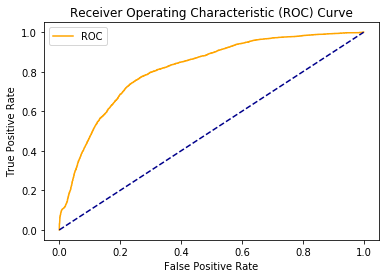

[[10230  1028]
 [ 1682  1984]]
              precision    recall  f1-score   support

           0     0.8588    0.9087    0.8830     11258
           1     0.6587    0.5412    0.5942      3666

    accuracy                         0.8184     14924
   macro avg     0.7587    0.7249    0.7386     14924
weighted avg     0.8096    0.8184    0.8121     14924



In [0]:
fpr, tpr, thresholds = roc_curve(y_test, probs)
plot_roc_curve(fpr, tpr)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred,digits=4))

In [0]:
gaussian = GaussianNB()
gaussian.fit(data_train,y_train)
score_gaussian = gaussian.score(data_test,y_test)
print('The accuracy of Gaussian Naive Bayes is', score_gaussian)
probs = gaussian.predict_proba(data_test)
probs = probs[:,1]
auc_score = roc_auc_score(y_test, probs)
print("AUC: %.4f" % auc_score)

The accuracy of Gaussian Naive Bayes is 0.7946261056017153
AUC: 0.8146


### Neuronske mreze

In [0]:
X_train, X_test,y_train, y_test = train_test_split(minmax_stand.drop("Income",axis=1),minmax_stand["Income"], test_size=0.33, random_state=50)

In [0]:
from sklearn.neural_network import MLPClassifier  
mlp = MLPClassifier(hidden_layer_sizes=(10, 10, 10), max_iter=1000, random_state=1)  
mlp.fit(X_train, y_train.values.ravel()) 
predictions = mlp.predict(X_test)
from sklearn.metrics import classification_report, confusion_matrix  
print(confusion_matrix(y_test,predictions))  
print(classification_report(y_test,predictions,digits=4))
probs = mlp.predict_proba(X_test)
probs = probs[:,1]
auc_score = roc_auc_score(y_test, probs)
print("AUC: %.4f" % auc_score)

[[10360   898]
 [ 1317  2349]]
              precision    recall  f1-score   support

           0     0.8872    0.9202    0.9034     11258
           1     0.7234    0.6408    0.6796      3666

    accuracy                         0.8516     14924
   macro avg     0.8053    0.7805    0.7915     14924
weighted avg     0.8470    0.8516    0.8484     14924

AUC: 0.9102


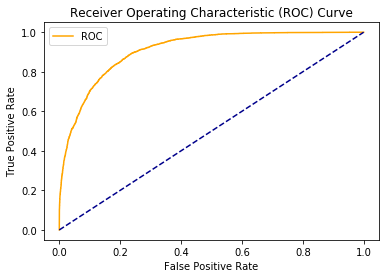

In [0]:
fpr, tpr, thresholds = roc_curve(y_test, probs)
plot_roc_curve(fpr, tpr)

In [0]:
from sklearn.neural_network import MLPClassifier  
mlp = MLPClassifier(hidden_layer_sizes=(13, 13, 13, 13), max_iter=1000, random_state=1)  
mlp.fit(X_train, y_train.values.ravel())
predictions = mlp.predict(X_test)
from sklearn.metrics import classification_report, confusion_matrix  
print(confusion_matrix(y_test,predictions))  
print(classification_report(y_test,predictions,digits=4))
probs = mlp.predict_proba(X_test)
probs = probs[:,1]
auc_score = roc_auc_score(y_test, probs)
print("AUC: %.4f" % auc_score)

[[10356   902]
 [ 1352  2314]]
              precision    recall  f1-score   support

           0     0.8845    0.9199    0.9019     11258
           1     0.7195    0.6312    0.6725      3666

    accuracy                         0.8490     14924
   macro avg     0.8020    0.7755    0.7872     14924
weighted avg     0.8440    0.8490    0.8455     14924

AUC: 0.9051


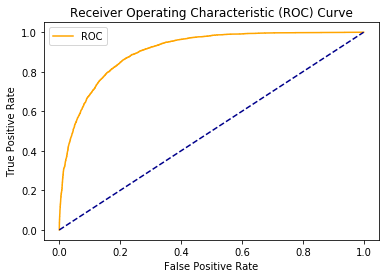

In [0]:
fpr, tpr, thresholds = roc_curve(y_test, probs)
plot_roc_curve(fpr, tpr)

In [0]:
from sklearn.neural_network import MLPClassifier  
mlp = MLPClassifier(hidden_layer_sizes=(13, 13, 13), max_iter=500, random_state=1, solver='sgd')  
mlp.fit(X_train, y_train.values.ravel()) 
predictions = mlp.predict(X_test)
from sklearn.metrics import classification_report, confusion_matrix  
print(confusion_matrix(y_test,predictions))  
print(classification_report(y_test,predictions,digits=4))
probs = mlp.predict_proba(X_test)
probs = probs[:,1]
auc_score = roc_auc_score(y_test, probs)
print("AUC: %.4f" % auc_score)

[[10334   924]
 [ 1283  2383]]
              precision    recall  f1-score   support

           0     0.8896    0.9179    0.9035     11258
           1     0.7206    0.6500    0.6835      3666

    accuracy                         0.8521     14924
   macro avg     0.8051    0.7840    0.7935     14924
weighted avg     0.8481    0.8521    0.8495     14924

AUC: 0.9096


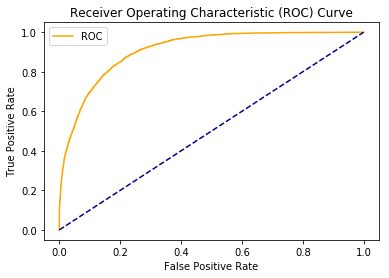

In [0]:
fpr, tpr, thresholds = roc_curve(y_test, probs)
plot_roc_curve(fpr, tpr)

## Usporedba algoritama

U ovom odjeljku usporedit ćemo uspješnost mjera evaluacija prije analiziranih algoritama.

ROC_AUC

 / |Log. Reg. | Log. Reg (PCA)|R Forest | R Forest (PCA)|SVM | SVM (PCA)|KNN | KNN (PCA)| Naive Bayes | Naive Bayes (PCA)|Neuronske mreže
--- | --- | ---| --- | ---| --- | ---| --- | ---| --- | ---| ---
No Scaling |0.9039 | - | 0.8909 | - | - | -|0.6353|-|0.8055|-|0.8690
StandardScaler|0.9071 | 0.9026 |0.8959 |0.9054 | 0.9047| 0.9005| 0.8669| 0.8642| 0.8344|0.8586| 0.9127
RobustScaler|0.9071| 0.7921 | 0.8541 | - | - | -| 0.8903| 0.8034| 0.7906| 0.7856| 0.9121
MinMaxScaler|0.9071 | 0.8777 | 0.9079| 0.8630 | 0.9043 | 0.8606|0.8505| 0.8329| 0.8568| 0.8170| 0.9102


Accuracy

 / |Log. Reg. | Log. Reg (PCA)|Random Forest | Random Forest (PCA)|SVM | SVM (PCA)|KNN | KNN (PCA)| Naive Bayes | Naive Bayes (PCA)|Neuronske mreže
--- | --- | ---| --- | ---| --- | ---| --- | ---| --- | ---| ---
No Scaling |0.8552 | -| 0.8379 | - | - | -|0.7337|-|0.7889|-|0.7946
StandardScaler|0.8508 | 0.8465 |0.8571 | 0.8450 | 0.8583 | 0.8472| 0.8303| 0.8342| 0.6235| 0.7921| 0.8556
RobustScaler|0.8509 | 0.7921 | 0.8565 | 0.8279 | - | -| 0.8542| 0.8055| 0.7906|0.7856| 0.8544
MinMaxScaler|0.8504 | 0.8256 | 0.8542| 0.8194 | 0.8486 | 0.8252| 0.8261| 0.8169| 0.6062|0.74363| 0.8525

### Zakljucak

Najbolje rezultate daju logistička regresija, SVM, Random Forest te neuronske mreže i to bez primjene PCA. Najbolji rezultat što se tiče ROC_AUC vrijednosti daju neuronske mreže, dok najveću točnost daje SVM sa StandardScaler-om.

## Literatura

[1] UCI Machine Learning Repository http://archive.ics.uci.edu/ml/datasets/adult

[2] http://robotics.stanford.edu/~ronnyk/nbtree.pdf

[3] https://storage.googleapis.com/kaggle-forum-message-attachments/160002/5905/Paper%20on%20Machine%20Learning%20for%20Kaggle.pdf

[4] http://robotics.stanford.edu/~ronnyk/nbtree.pdf  Ron Kohavi, "Scaling Up the Accuracy of Naive-Bayes Classifiers: a Decision-Tree Hybrid", Proceedings of the Second International Conference on Knowledge Discovery and Data Mining, 1996 

[5] https://towardsdatascience.com/normalization-vs-standardization-quantitative-analysis-a91e8a79cebf

[6] https://scikit-learn.org/stable/index.html

[7] http://www.dataminingmasters.com/uploads/studentProjects/Earning_potential_report.pdf

[8] https://github.com/pmf-strojnoucenje/Vjezbe

[9] https://scikit-learn.org/stable/modules/svm.html

[10] https://scikit-learn.org/stable/modules/neighbors.html

[11] https://scikit-learn.org/stable/modules/naive_bayes.html